In [97]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time

plt.rcParams.update({'font.size': 14})
# pd.set_option('display.float_format', lambda x: '%.2e' % x)

ATTENTION: possible bug introduced through wrong application of np.append method

In [98]:
# data = simplesim.Manager( directory="./data", filetype="nc")
# diag = simplesim.Manager( executable="./feltordiag.sh", directory="diag", filetype="nc")
# plot = simplesim.Manager( executable ="./feltorplot.sh", directory="plot", filetype = "nc")
data = simplesim.Manager( directory="./resistivity-scan-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-scan-diag", filetype="nc")

In [99]:
content = data.table()
print( f"The database contains {np.size(content)} simulations")
i = 0
for pp in content:
    
    print( data.outfile( pp), " split into ", data.count( pp), " file(s)", i)
    i+=1

The database contains 12 simulations
./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc  split into  10  file(s) 0
./resistivity-scan-data/2e759a6ae7dfd3a2892e71ddce6a89f7f1e327b6.nc  split into  6  file(s) 1
./resistivity-scan-data/33752dd60b65c471ded739466e3f196ad1c410d9.nc  split into  10  file(s) 2
./resistivity-scan-data/463a0f4a25854a159d77c5c8742d8ff25db24298.nc  split into  6  file(s) 3
./resistivity-scan-data/7f206f98b2083b20a6c5a69036c291e877623c7d.nc  split into  6  file(s) 4
./resistivity-scan-data/8018809091944c0999b258c85eab09171a919ff2.nc  split into  10  file(s) 5
./resistivity-scan-data/922c17c817a756e4632e15bc86464abc60f45628.nc  split into  10  file(s) 6
./resistivity-scan-data/b4e0ad324b9df18a452b3947b4b8784b25262e6e.nc  split into  6  file(s) 7
./resistivity-scan-data/b826023234bf8ff7efa999f0a60ebde32a7676c7.nc  split into  4  file(s) 8
./resistivity-scan-data/c857bb29fb57ca1f7f563fd16dc9c26afc644f18.nc  split into  10  file(s) 9
./resistivity-scan

In [100]:
config = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fx_0" : 0.125,
        "fsa" : "toroidal-average", # or "convoluted-toroidal-average"
        "diagnostics":
        [
            "fsa",
            # "fsa2d",
            "cta2d",
            # "cta2dX",  
            # "fluc2d", # these can also be computed from cta2d, fsa2d
            "ifs",
            "std_fsa",
            "ifs_lcfs",
            "ifs_norm"
        ],
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "time-reduction-factor" : 10
    }

with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [101]:
# time.sleep(3600)
for pp in content :
    for i in range( 0, data.count(pp)) :
        print( "Diag ", data.outfile( pp), i)
        diag.create(pp,i,error="display")
#         print( "Plot ", data.outfile( pp), i)
#         plot.create(pp,i,error="display")

Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 0
Existing simulation 09921d...55799b.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 1
Existing simulation 09921d...99b0x1.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 2
Existing simulation 09921d...99b0x2.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 3
Existing simulation 09921d...99b0x3.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 4
Existing simulation 09921d...99b0x4.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 5
Existing simulation 09921d...99b0x5.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 6
Existing simulation 09921d...99b0x6.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 7
Existing simulation 09921d...99b0x7.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 8
Exis

Existing simulation f861b2...3640x6.nc
Diag  ./resistivity-scan-data/f861b2031ceca72b26ede2111cd19b65626da364.nc 7
Existing simulation f861b2...3640x7.nc
Diag  ./resistivity-scan-data/f861b2031ceca72b26ede2111cd19b65626da364.nc 8
Existing simulation f861b2...3640x8.nc
Diag  ./resistivity-scan-data/f861b2031ceca72b26ede2111cd19b65626da364.nc 9
Existing simulation f861b2...3640x9.nc


In [102]:
def create_merged_dataset( manager, params ) :
    datasetpaths = [manager.outfile(params,i) for i in range(manager.count(params))]
    return xfeltor.open_feltordataset( datasetpaths)


In [103]:
# This cell may take a minute ...
content = diag.table()
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    file = create_merged_dataset( diag, pp)
    pp['file'] = file
    

1e-06 1.0
0.0001 0.0
0.0001 1.0
3e-05 0.0
3e-06 0.0
1e-05 1.0
0.0003 1.0
1e-05 0.0
0.0003 0.0
3e-05 1.0
1e-06 0.0
3e-06 1.0


In [104]:
da0 = Dataset( diag.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]

1e-06 1.0
Invert for given numerical parameters
0.0001 0.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
3e-05 0.0
Invert for given numerical parameters
3e-06 0.0
Invert for given numerical parameters
1e-05 1.0
Invert for given numerical parameters
0.0003 1.0
Invert for given numerical parameters
1e-05 0.0
Invert for given numerical parameters
0.0003 0.0
Invert for given numerical parameters
3e-05 1.0
Invert for given numerical parameters
1e-06 0.0
Invert for given numerical parameters
3e-06 1.0
Invert for given numerical parameters


In [105]:
# sort parameters
content = sorted(content, key=lambda pp: (pp['physical']['resistivity'], pp['physical']['tau']))
for pp in content :
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    da = pp['file']


1e-06 0.0
1e-06 1.0
3e-06 0.0
3e-06 1.0
1e-05 0.0
1e-05 1.0
3e-05 0.0
3e-05 1.0
0.0001 0.0
0.0001 1.0
0.0003 0.0
0.0003 1.0


In [106]:
# drop last index in one sim because it crashed
# USE ONLY ONCE
for pp in content :
    if pp['physical']['resistivity'] == 3e-4 and  pp['physical']['tau'] == 0 :
        pp['file'] = pp['file'].drop_isel(time = [-1])
#         print( pp['physical']['resistivity'], pp['physical']['tau'])
#         print( pp['file'])

In [107]:
min_idx_dict = {
    0 : {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150},
    1 : {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150}          
} # in cs/R0

### Mass flux out of separatrix

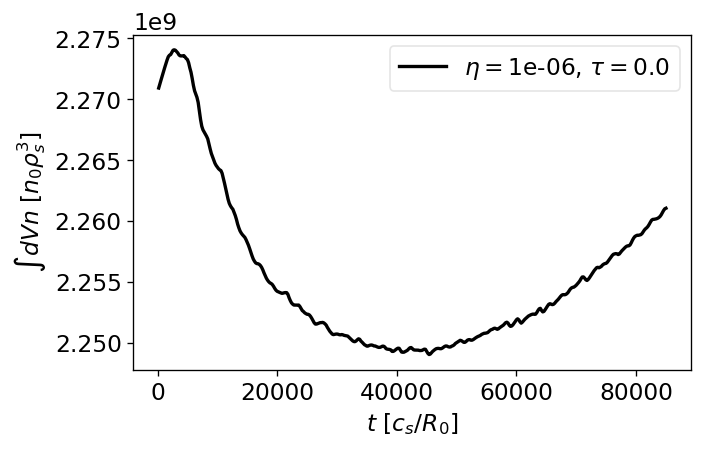

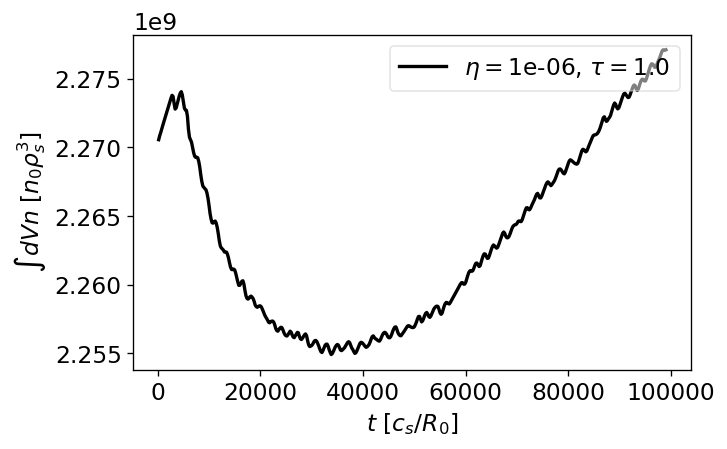

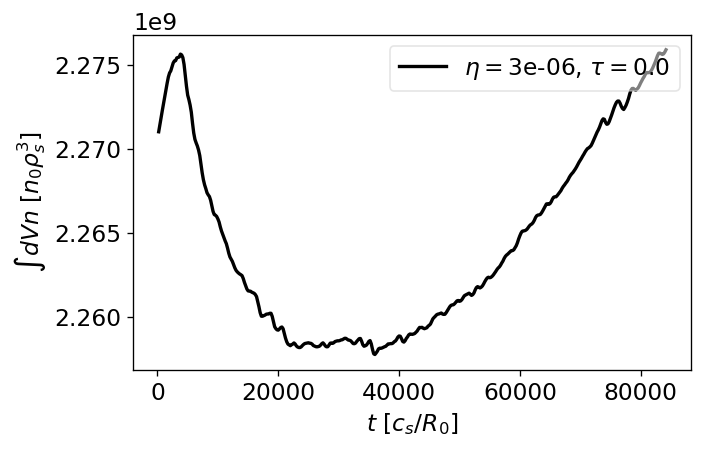

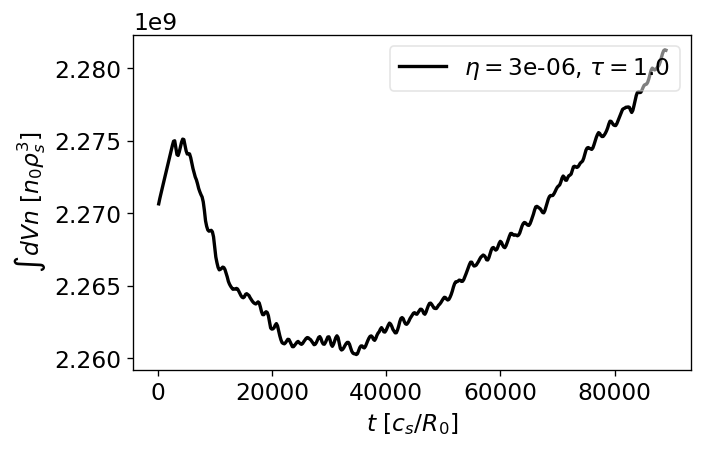

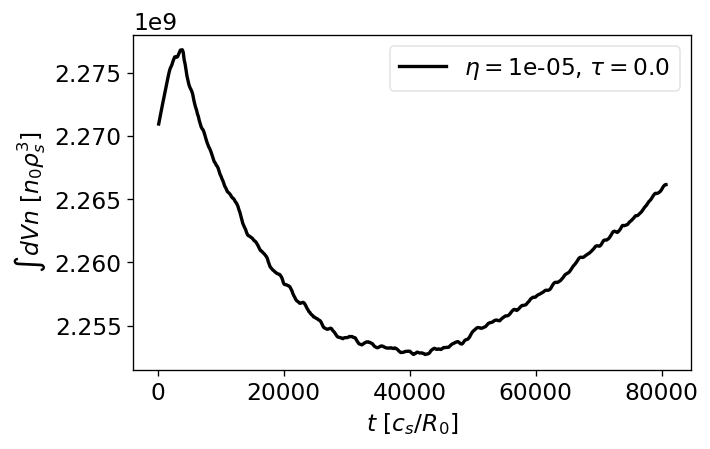

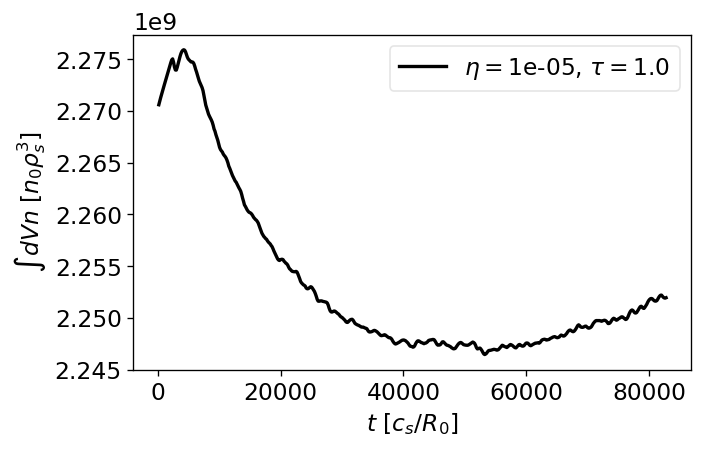

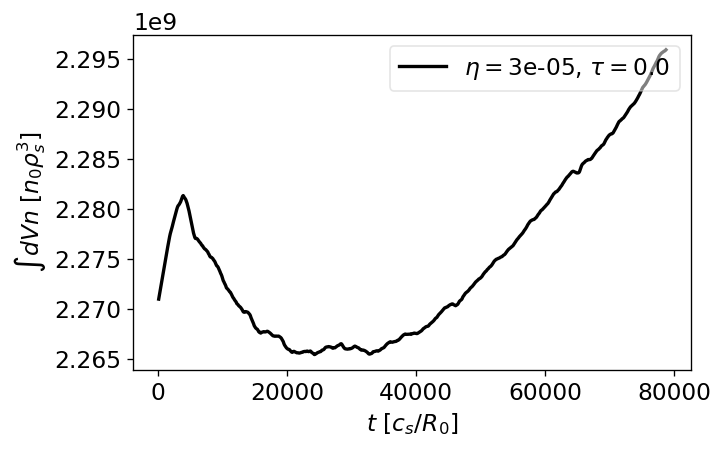

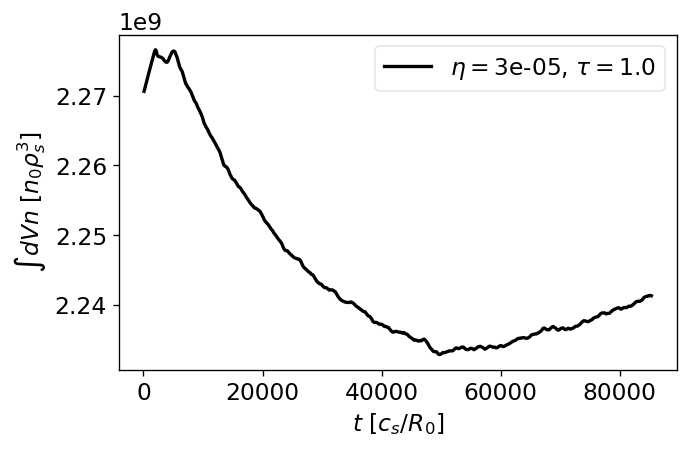

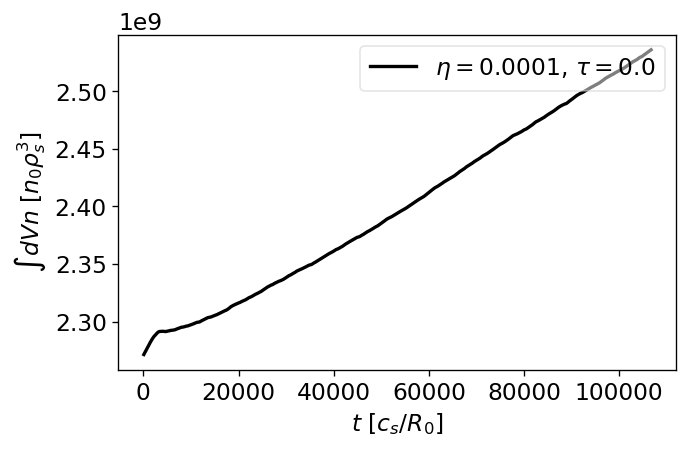

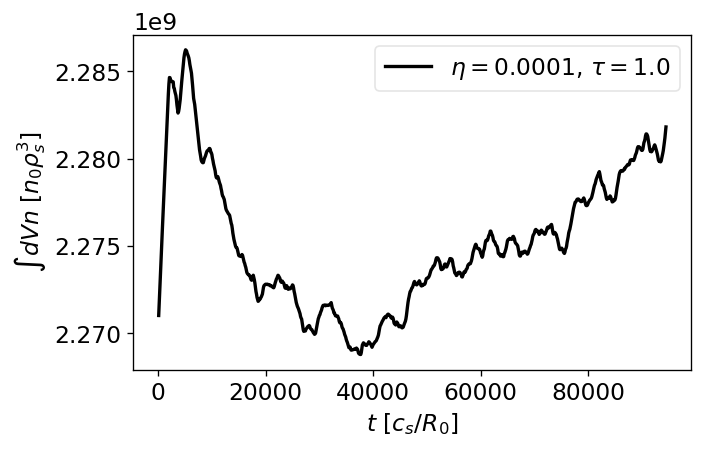

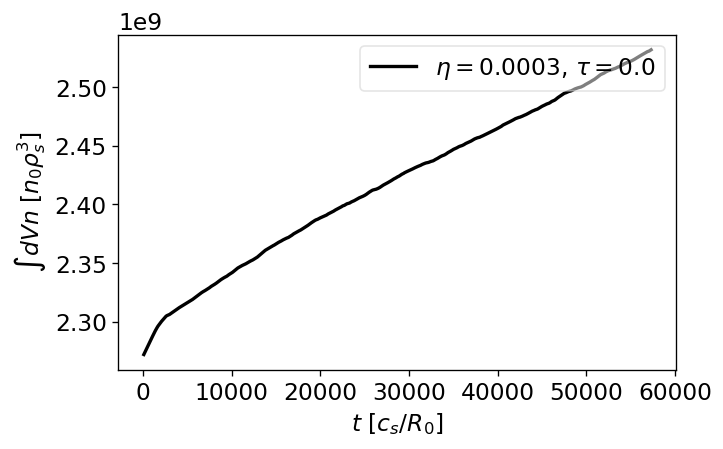

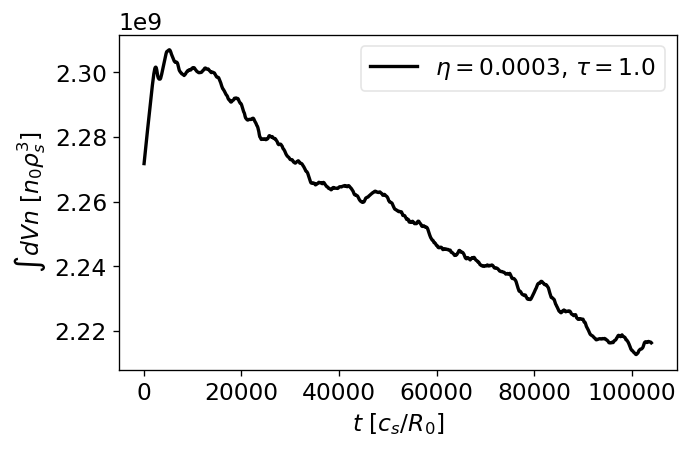

In [108]:
### PLOT OF TOTAL MASS CONTAINED WITHIN SEPARATRIX
for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
    time = np.asarray(da['time'][:])
    
#     print( pp["physical"])
#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
    timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][:])

    plt.plot(time[1:]*timescale,mass[1:], color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}'
            )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\int dV n\ [n_0\rho_s^3]$")

    plt.show(   )

Average flux is 3.84e-04 pm 7.65e-05
Total average mass loss rate is 1887.8
Total mass gain by sources is 2096.9
particle confinement time = 1.96e+01


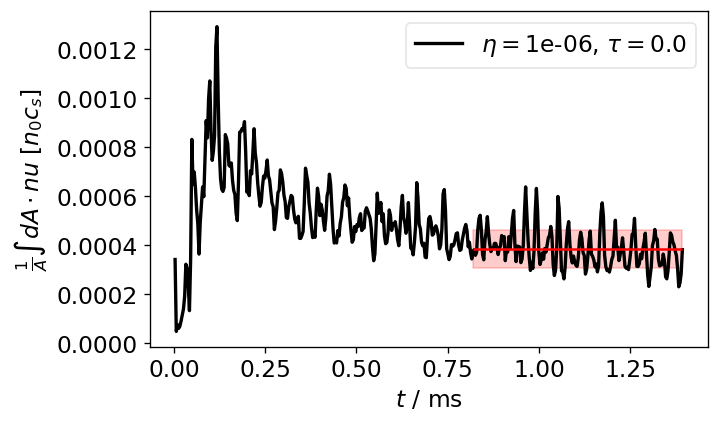

Average flux is 3.49e-04 pm 1.31e-04
Total average mass loss rate is 1717.3
Total mass gain by sources is 2096.9
particle confinement time = 2.16e+01


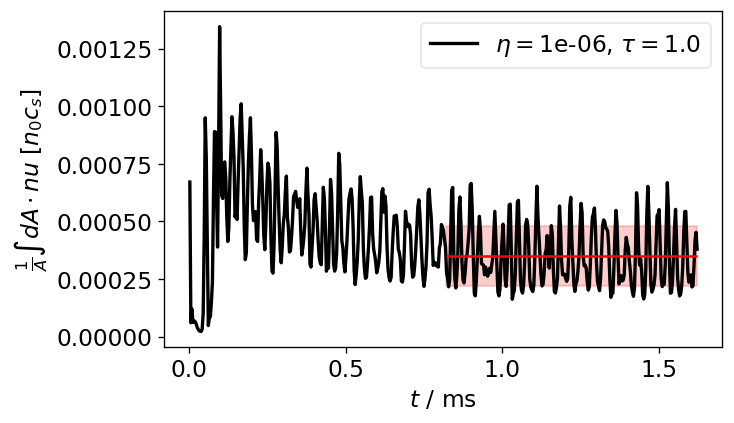

Average flux is 4.49e-04 pm 8.28e-05
Total average mass loss rate is 2209.2
Total mass gain by sources is 2516.2
particle confinement time = 2.21e+01


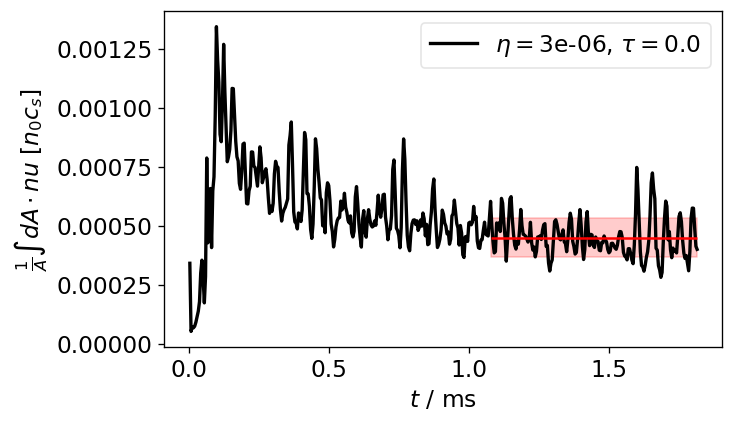

Average flux is 4.31e-04 pm 1.28e-04
Total average mass loss rate is 2120.3
Total mass gain by sources is 2516.2
particle confinement time = 2.31e+01


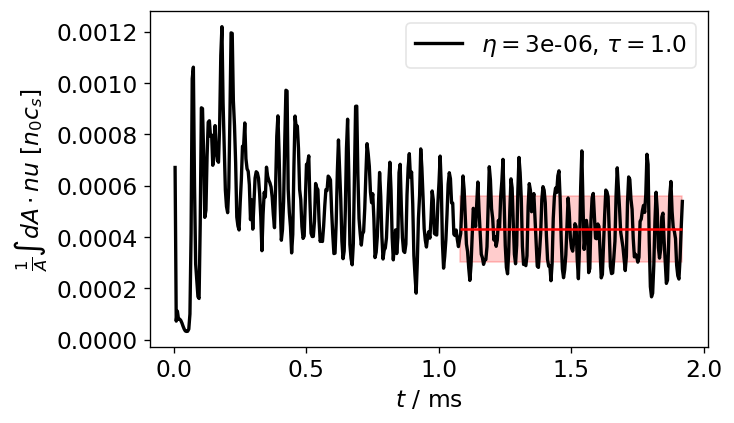

Average flux is 5.56e-04 pm 6.68e-05
Total average mass loss rate is 2732.3
Total mass gain by sources is 2935.6
particle confinement time = 2.41e+01


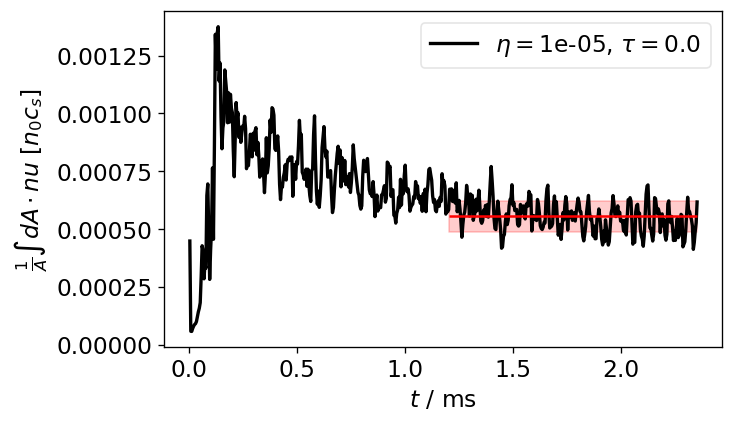

Average flux is 5.91e-04 pm 1.07e-04
Total average mass loss rate is 2905.7
Total mass gain by sources is 2935.6
particle confinement time = 2.25e+01


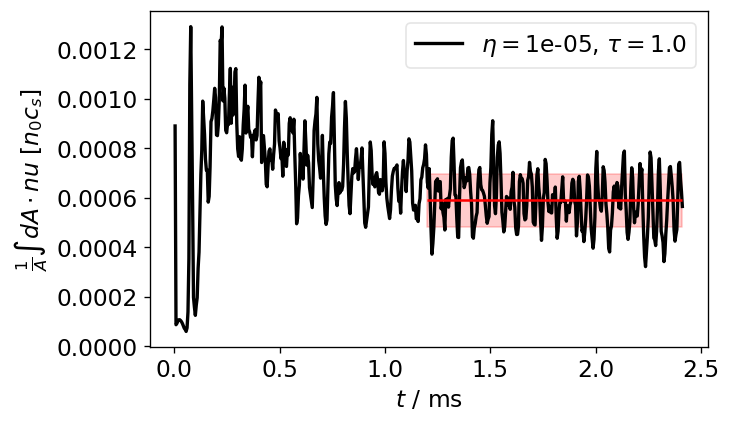

Average flux is 7.24e-04 pm 8.07e-05
Total average mass loss rate is 3562.0
Total mass gain by sources is 4193.7
particle confinement time = 2.46e+01


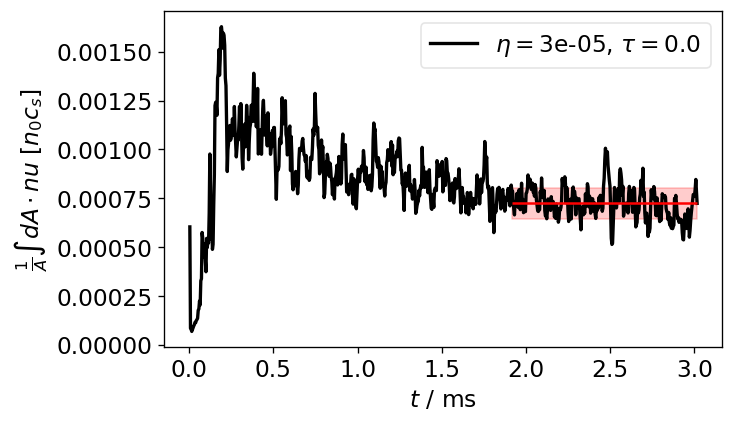

Average flux is 8.32e-04 pm 9.32e-05
Total average mass loss rate is 4089.9
Total mass gain by sources is 4193.7
particle confinement time = 2.10e+01


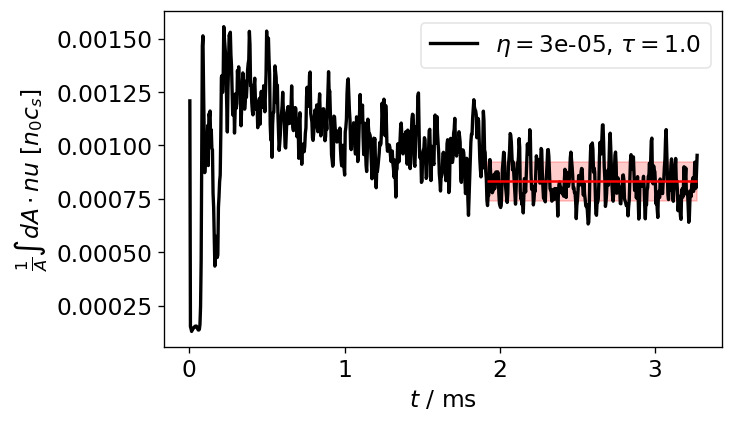

Average flux is 1.23e-03 pm 1.12e-04
Total average mass loss rate is 6029.5
Total mass gain by sources is 8387.4
particle confinement time = 2.08e+01


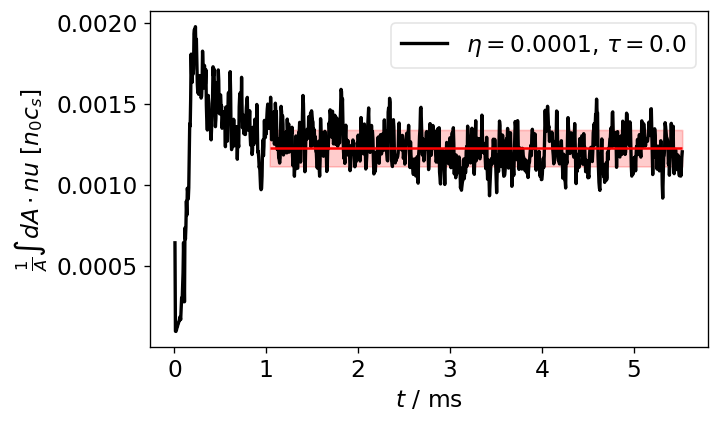

Average flux is 1.73e-03 pm 1.87e-04
Total average mass loss rate is 8521.4
Total mass gain by sources is 8387.4
particle confinement time = 1.38e+01


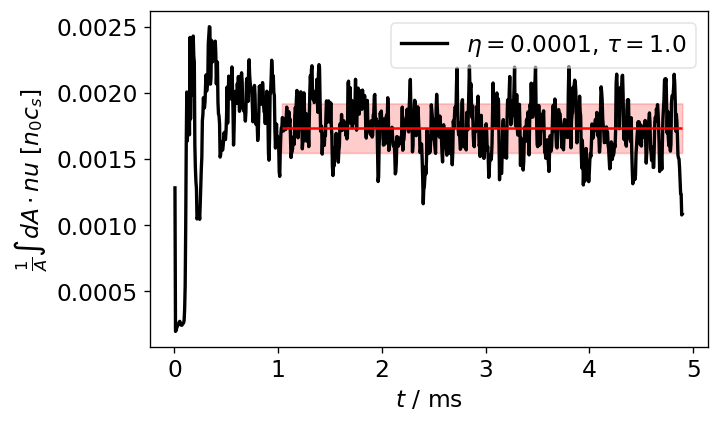

Average flux is 2.67e-03 pm 1.98e-04
Total average mass loss rate is 13156.3
Total mass gain by sources is 16774.8
particle confinement time = 1.27e+01


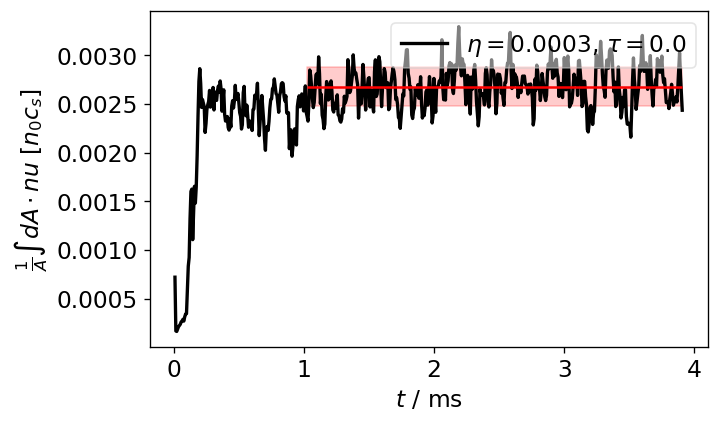

Average flux is 3.73e-03 pm 3.98e-04
Total average mass loss rate is 18340.3
Total mass gain by sources is 16774.8
particle confinement time = 8.36e+00


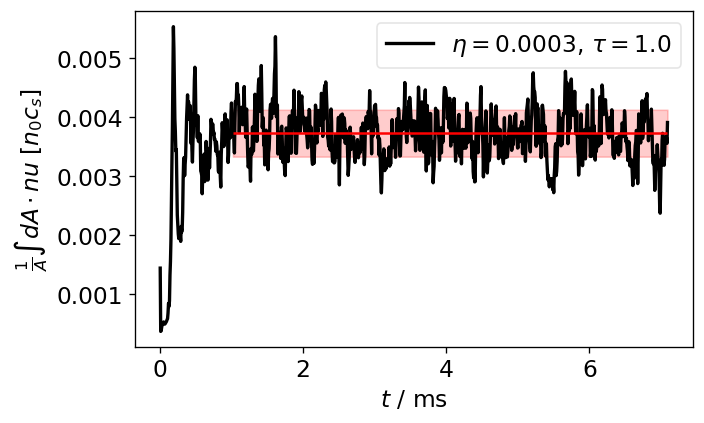

In [109]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')

    da = pp['file']

#     with open( "test-file.json","w") as f:
#         f.write(da.inputfile)
    
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    jvne=np.asarray(da['jvneC_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['jvneE_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['jvneA_tt_ifs_lcfs'][:])/deltat
    divjvne = np.asarray(da["divjnepar_tt_ifs_lcfs"][:])/deltat
    average_mass = np.mean(mass[min_idx:])
    sigma_mass = mass[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    #### Fill in parameters list #####
    pp['physical']['average_mass_flux_lcfs'] = average_jvne
    pp['physical']['average_mass_ifs'] = average_mass
    pp['physical']['sigma_mass_flux_lcfs'] = sigma_jvne
    pp['physical']['sigma_mass_ifs'] = sigma_mass
    ###################################
    source = np.asarray(da["sne_tt_ifs_lcfs"][:])/deltat
    average_source = source[min_idx:].mean()
    area = pp['area'][pp['lcfs']]
    print( f"Average flux is { average_jvne/area:1.2e} pm {sigma_jvne/area:1.2e}")
    print( f"Total average mass loss rate is {average_jvne:6.1f}")
    print( f"Total mass gain by sources is {average_source:6.1f}" )
    print( f"particle confinement time = {average_mass/average_jvne*timescale:1.2e}")
    tau = mass/jvne
    indices = range(min_idx,np.size(time))
    plt.plot(time[1:]*timescale,jvne[1:]/area, color='k', 
#     plt.plot(indices,jvne[min_idx:]/area, color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}'
            )
    plt.hlines(average_jvne/area,
               time[min_idx]*timescale, time[-1]*timescale, color='r')
    plt.fill_between( time[min_idx:]*timescale, (average_jvne-sigma_jvne)/area, 
                      (average_jvne+sigma_jvne)/area, color='red', alpha=0.2)
#     plt.hlines(indices, time[0]*timescale, time[len(time)-1]*timescale, color='k')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ /\ $ms")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    if pp['physical']['tau'] == 1 and pp['physical']['resistivity'] == 1e-4:
        plt.savefig( 'mass-flux.png',bbox_inches='tight')
    plt.show(   )


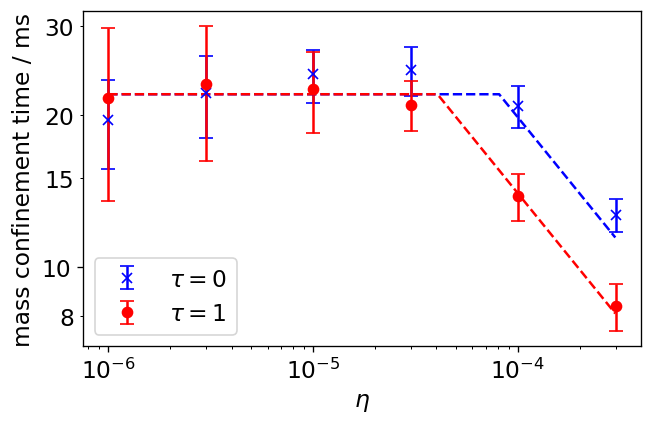

In [110]:
resistivities = {0: [], 1: []}
confinement_times = {0: [], 1: []}
confinement_errs = {0: [], 1: []}
models = {0: [], 1: []}
for pp in content:
    phys= pp['physical']
    resistivities[phys['tau']].append(phys['resistivity'])
    timescale = fp.omega_0_inv(**phys)*1e3 # ms
#     timescale = 1./545.# in cs/R_0
    confinement_times[phys['tau']].append(
        phys['average_mass_ifs']/phys['average_mass_flux_lcfs']*timescale)
 
    confinement_errs[phys['tau']].append(
        np.sqrt((phys['sigma_mass_ifs']/phys['average_mass_flux_lcfs'])**2 + 
                (phys['average_mass_ifs']/phys['average_mass_flux_lcfs']**2*phys['sigma_mass_flux_lcfs'])**2)*
                timescale)
lin_res = np.arange( 1e-6, 3e-4, 1e-6)
for res in lin_res:
    if res > 2*4e-5: 
        models[0].append(
            np.sqrt(2)*0.0014*(1e-4*res)**(-0.5)
        )
    else:
        models[0].append(22)
    if res > 4e-5: 
        models[1].append(
            0.0014*(1e-4*res)**(-0.5)
        )
    else:
        models[1].append(22)
##########################
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
# Plot error bar 
# label axes
ax.errorbar( resistivities[0], confinement_times[0],
             yerr=confinement_errs[0], marker='x', ls='',label=r'$\tau=0$',
            color = 'b',capsize=4)
ax.errorbar( resistivities[1], confinement_times[1],
             yerr=confinement_errs[1], marker='o', ls='',label=r'$\tau=1$',
            color = 'r',capsize=4)
ax.plot( lin_res, models[0], ls='--', color = 'b')
ax.plot( lin_res, models[1], ls='--', color = 'r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\eta$')
ax.set_ylabel('mass confinement time / ms')
# Rewrite the y labels
ax.yaxis.set_major_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_minor_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.set_yticks( [8, 15, 20,30], minor = True)

plt.legend()
plt.savefig('mass_confinement_time.png',bbox_inches='tight')
plt.show()

### Volume Integrated Mass conservation

Resistivity = 1e-06, tau = 0.0
Average error = 50.87347982657804
Average delta = 315.6029041013257
Average source = 2096.8507299340454
Average jvne = 1887.7959615493373
Average lperp = 4.801176063461364


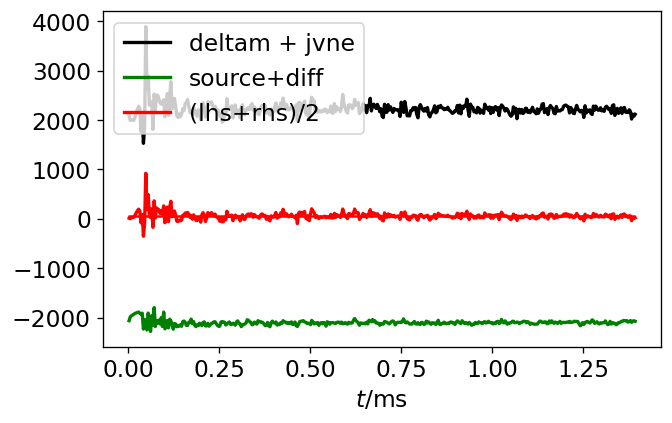

Resistivity = 1e-06, tau = 1.0
Average error = 10.569647762910932
Average delta = 411.2942235237215
Average source = 2096.8507299340795
Average jvne = 1717.2619170792698
Average lperp = 10.566115143089876


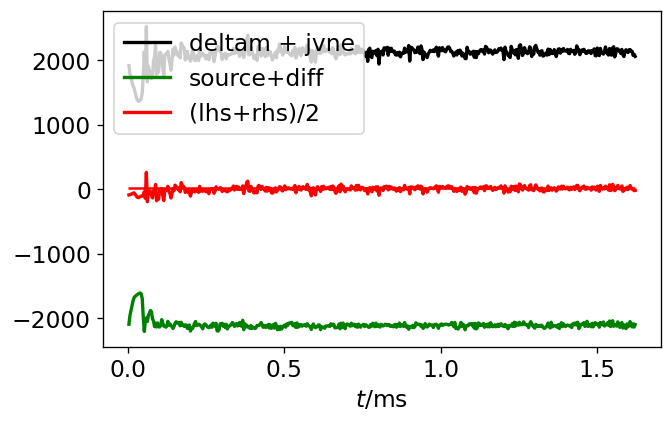

Resistivity = 3e-06, tau = 0.0
Average error = 61.46982714522122
Average delta = 433.54110299522097
Average source = 2516.2208759209166
Average jvne = 2209.168822157372
Average lperp = 3.5493949412344064


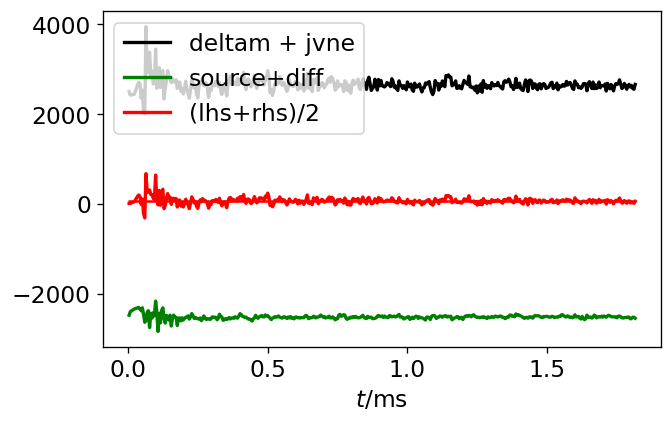

Resistivity = 3e-06, tau = 1.0
Average error = 14.605434154399388
Average delta = 439.99954050343854
Average source = 2516.2208759208625
Average jvne = 2120.2878274923464
Average lperp = 14.855623766123662


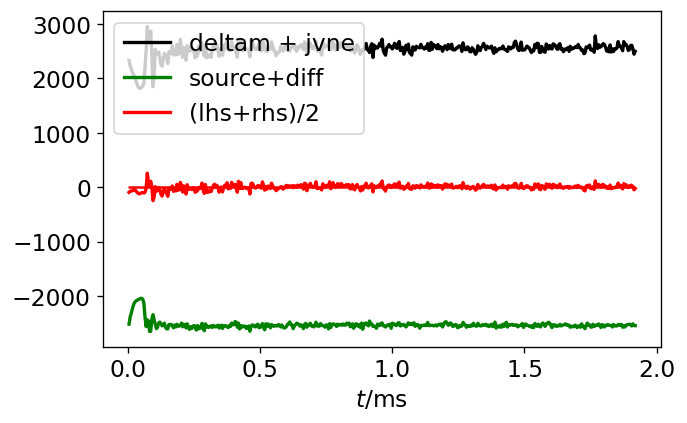

Resistivity = 1e-05, tau = 0.0
Average error = 63.0391684946506
Average delta = 335.2436628665226
Average source = 2935.591021907708
Average jvne = 2732.313242000354
Average lperp = 5.887545969867365


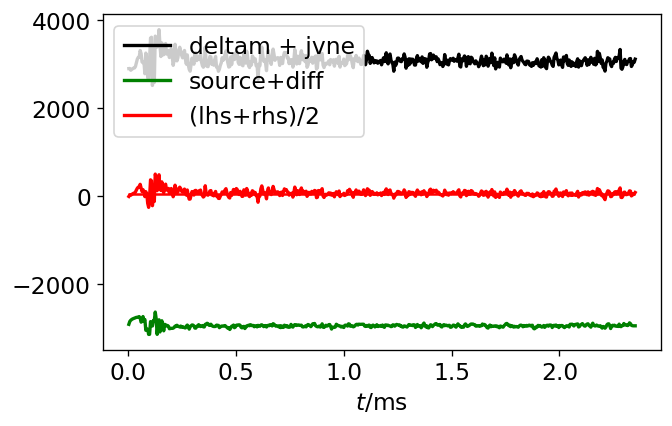

Resistivity = 1e-05, tau = 1.0
Average error = 30.47926631775136
Average delta = 112.22747054771268
Average source = 2935.591021907719
Average jvne = 2905.7422270299758
Average lperp = 21.420143034466726


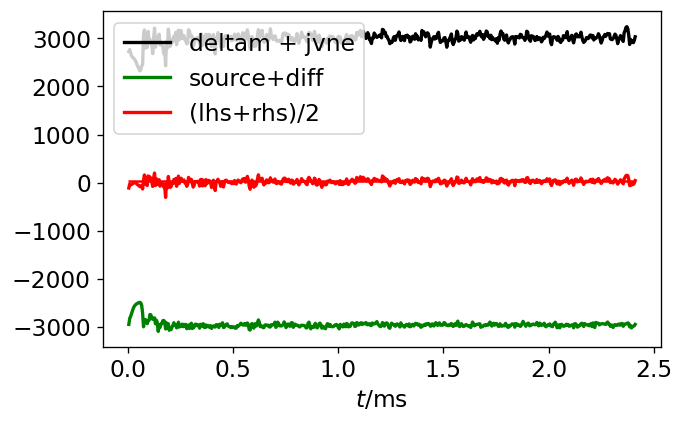

Resistivity = 3e-05, tau = 0.0
Average error = 82.99355133019006
Average delta = 793.8242553771702
Average source = 4193.701459868204
Average jvne = 3562.042477452797
Average lperp = -3.82182969861792


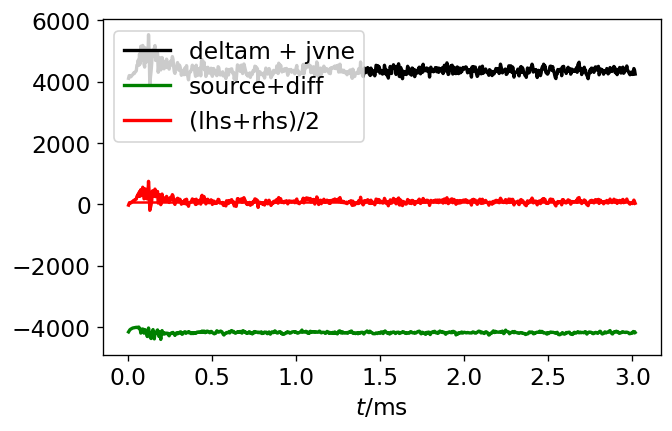

Resistivity = 3e-05, tau = 1.0
Average error = 54.901961088027655
Average delta = 237.0997815461751
Average source = 4193.701459868241
Average jvne = 4089.871456559311
Average lperp = 23.46585606119051


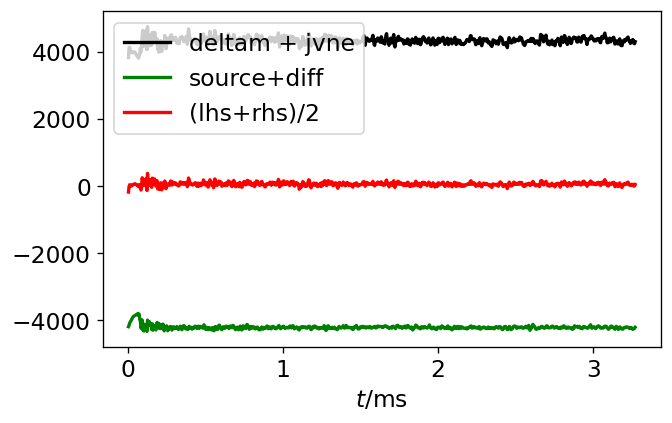

Resistivity = 0.0001, tau = 0.0
Average error = 98.88496511110972
Average delta = 2535.297385293339
Average source = 8387.40291973625
Average jvne = 6029.451272511675
Average lperp = -20.424192153456207


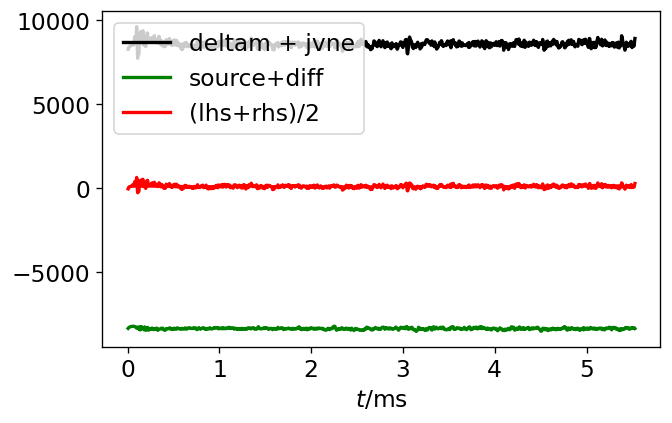

Resistivity = 0.0001, tau = 1.0
Average error = 121.0597517334162
Average delta = 121.03678518382219
Average source = 8387.402919736267
Average jvne = 8521.403267206648
Average lperp = 12.917629187370654


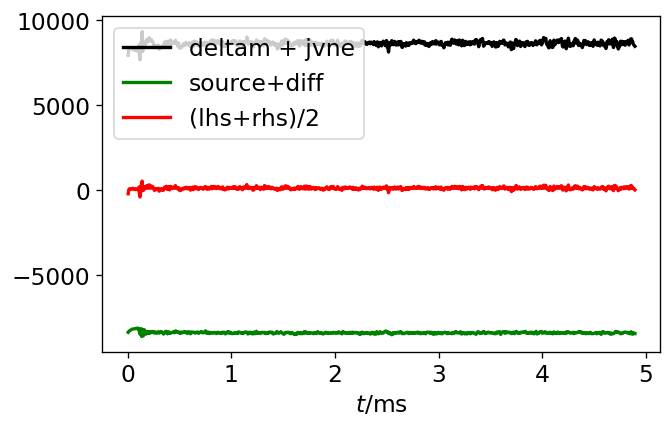

Resistivity = 0.0003, tau = 0.0
Average error = 140.59899627944162
Average delta = 3913.394586291685
Average source = 16774.805839472476
Average jvne = 13156.294221966697
Average lperp = 13.684976227024011


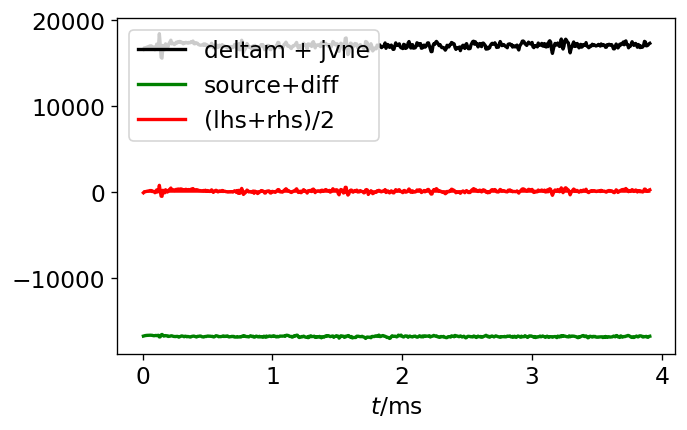

Resistivity = 0.0003, tau = 1.0
Average error = 312.02651158306577
Average delta = -924.1279038950623
Average source = 16774.805839472676
Average jvne = 18340.316371481524
Average lperp = 17.329604947655397


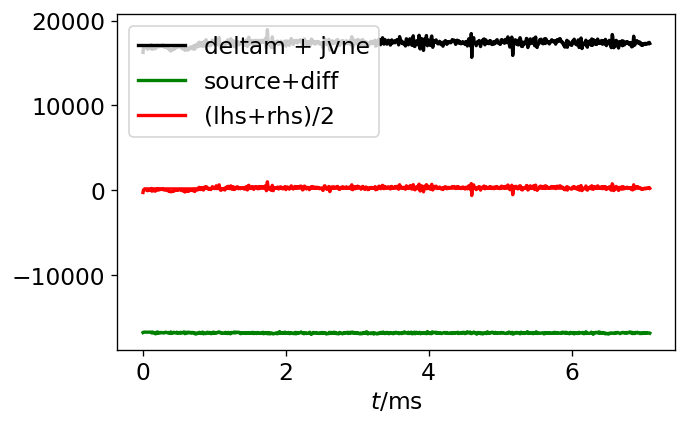

In [127]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')

    da = pp['file']
    time = np.asarray(da['time'][:])
    deltat = np.diff(np.append(time, 2*time[-1] -time[-2]))
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]

    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
    mass = np.asarray(da.variables['electrons_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)

    deltam = np.diff(masstt,axis=0)/deltat
    source = np.asarray(da.variables['sne_tt_ifs_lcfs'][:])/deltat
    
    jvneE= np.asarray(da['jvneE_tt_ifs_lcfs'][:])/deltat
    jvneC=np.asarray(da['jvneC_tt_ifs_lcfs'][:])/deltat
    jvneA=np.asarray(da['jvneA_tt_ifs_lcfs'][:])/deltat
    divjvnepar=np.asarray(da['divjnepar_tt_ifs_lcfs'][:])/deltat
    
    diff_perp = np.asarray(da["lneperp_tt_ifs_lcfs"][:])/deltat
    diff_para = np.asarray(da["lneparallel_tt_ifs_lcfs"][:])/deltat
    
#     deltamass=deltam - source
    jvne= jvneE+jvneC+jvneA#+divjvnepar
    lhs = deltam + jvne
#     rhs = jvne-diff_perp-diff_para
    rhs = source + diff_perp
    diff = (lhs - rhs)/2
    average_deltamass = np.mean(deltam[min_idx:])
    sigma_deltamass = deltam[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]) 
    sigma_jvne = jvne[min_idx:].std()
    average_diff = np.mean(diff[min_idx:])
    sigma_diff = diff[min_idx:].std()
    average_lperp = np.mean(diff_perp[min_idx:])
    sigma_lperp = diff_perp[min_idx:].std()
    #### Fill in parameters list #####
    pp['physical']['average_mass_flux_lcfs'] = average_jvne
    pp['physical']['average_deltamass_ifs'] = average_deltamass
    pp['physical']['sigma_mass_flux_lcfs'] = sigma_jvne
    pp['physical']['sigma_deltamass_ifs'] = sigma_deltamass
    pp['physical']['average_mass_error'] = average_diff
    pp['physical']['sigma_mass_error'] = sigma_diff
    pp['physical']['average_mass_source_ifs'] = np.mean(source[min_idx:])
    pp['physical']['average_mass_lperp'] = average_lperp
    pp['physical']['sigma_mass_lperp'] = sigma_lperp
    print(f'Resistivity = {pp["physical"]["resistivity"]}, tau = {pp["physical"]["tau"]}')
    print(f'Average error = {pp["physical"]["average_mass_error"]}')
    print(f'Average delta = {pp["physical"]["average_deltamass_ifs"]}')
    print(f'Average source = {pp["physical"]["average_mass_source_ifs"]}')
    print(f'Average jvne = {pp["physical"]["average_mass_flux_lcfs"]}')
    print(f'Average lperp = {pp["physical"]["average_mass_lperp"]}')
    plt.plot(time[1:]*timescale,lhs[1:], color='k', marker='',
              ls='-', lw=2,markeredgecolor='k', markersize=8, label="deltam + jvne")
    plt.plot(time[1:]*timescale,-rhs[1:], color='g', marker='',
              ls='-', lw=2,markeredgecolor='g', markersize=8, label="source+diff")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=2,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[-1]*timescale, color='r')
#     plt.plot(time[1:]*timescale,divjvnepar[1:], color='y', marker='',
#              ls='--', lw = 2, label="parallel")
#     plt.plot(time[1:]*timescale,jvneE[1:], color='b', marker='',
#              ls='--', lw = 2, label="jvneE")
#     plt.plot(time[1:]*timescale,jvneC[1:], color='c', marker='',
#              ls='--', lw = 2, label="jvneC")
#     plt.plot(time[1:]*timescale,jvneA[1:], color='m', marker='',
#              ls='--', lw = 2, label="jvneA")
#     plt.plot(time[1:]*timescale,deltam[1:], color='k', marker='',
#              ls='--', lw = 2, label="deltam")
#     plt.plot(time[1:]*timescale,source[1:], color='k', marker='',
#              ls='--', lw = 2, label="source")

    da.close()
    plt.legend()
    plt.xlabel(r"$t/$ms")

    plt.show(   )

In [146]:
resistivities = {0: [], 1: []}
delta_avg = {0: [], 1: []}
delta_err = {0: [], 1: []}
jvne_avg = {0: [], 1: []}
jvne_err = {0: [], 1: []}
lperp_avg = {0: [], 1: []}
lperp_err = {0: [], 1: []}
source_avg = {0: [], 1: []}
error_avg = {0: [], 1: []}
error_err = {0: [], 1: []}

for pp in content:
    phys= pp['physical']
    resistivities[phys['tau']].append(phys['resistivity'])
    delta_avg[phys['tau']].append(phys['average_deltamass_ifs'])
    delta_err[phys['tau']].append(phys['sigma_deltamass_ifs'])
    jvne_avg[phys['tau']].append(phys['average_mass_flux_lcfs'])
    jvne_err[phys['tau']].append(phys['sigma_mass_flux_lcfs'])
    lperp_avg[phys['tau']].append(phys['average_mass_lperp'])
    lperp_err[phys['tau']].append(phys['sigma_mass_lperp'])
    source_avg[phys['tau']].append(phys['average_mass_source_ifs'])
    error_avg[phys['tau']].append(phys['average_mass_error'])
    error_err[phys['tau']].append(phys['sigma_mass_error'])

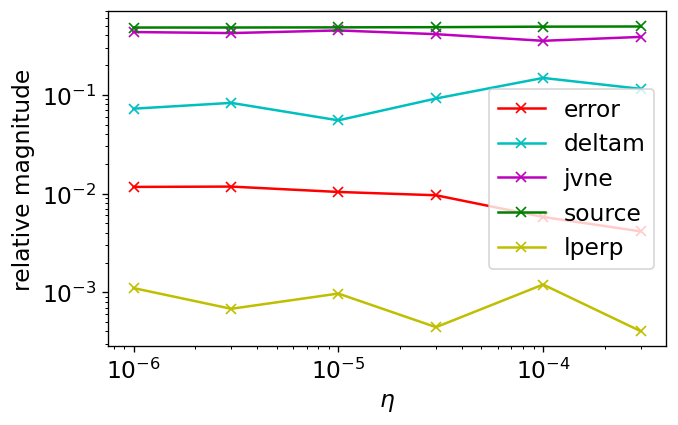

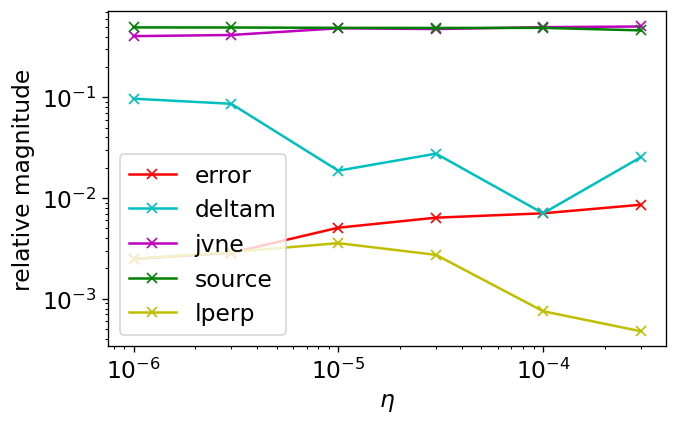

In [157]:
##########################

for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    summe = np.array(np.abs(delta_avg[tau]) +np.abs(jvne_avg[tau]) + 
             np.abs(lperp_avg[tau]) +np.abs(source_avg[tau])+np.abs(error_avg[tau]))
# Plot error bar 
# label axes
    ax.plot( resistivities[tau], error_avg[tau]/summe,
    #                  yerr=delta_err[tau],capsize=4
            marker='x', ls='-',label=r"error",  color = 'r')
    ax.plot( resistivities[tau], np.abs(delta_avg[tau])/summe,
            #                  yerr=delta_err[tau],capsize=4
            marker='x', ls='-',label=r"deltam",  color = 'c')
    ax.plot( resistivities[tau], jvne_avg[tau]/summe,
            #                  yerr=delta_err[tau],capsize=4
            marker='x', ls='-',label=r"jvne",  color = 'm')
    ax.plot( resistivities[tau],source_avg[tau]/summe,
    #                  yerr=delta_err[tau],capsize=4
            marker='x', ls='-',label=r"source",  color = 'g')
    ax.plot( resistivities[tau],np.abs(lperp_avg[tau])/summe,
    #                  yerr=delta_err[tau],capsize=4
            marker='x', ls='-',label=r"lperp",  color = 'y')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel('relative magnitude')

    plt.legend()
    plt.savefig('mass-error-t'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

## Energy conservation

Average flux is 1.60e-04 pm 3.66e-05
Total average energy loss rate is  788.8
Total energy gain by sources is 6722.1
Energy confinement time = 8.08e+01


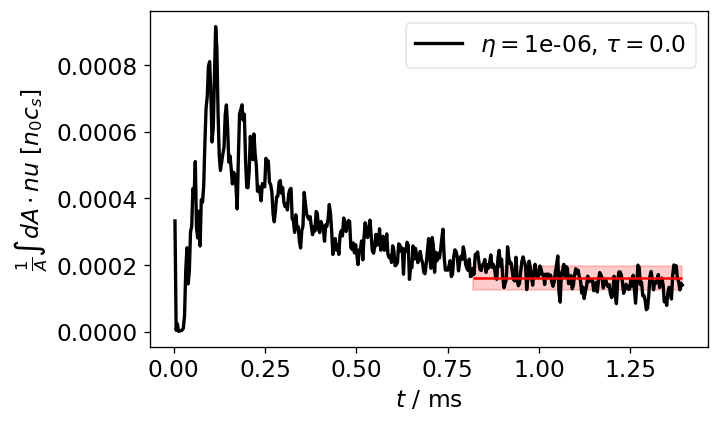

Average flux is 2.49e-04 pm 8.60e-05
Total average energy loss rate is 1222.7
Total energy gain by sources is 13463.4
Energy confinement time = 1.05e+02


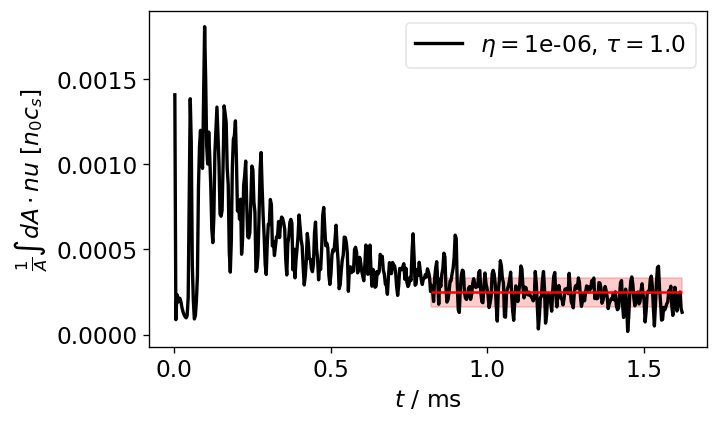

Average flux is 2.13e-04 pm 3.39e-05
Total average energy loss rate is 1048.8
Total energy gain by sources is 8118.5
Energy confinement time = 8.08e+01


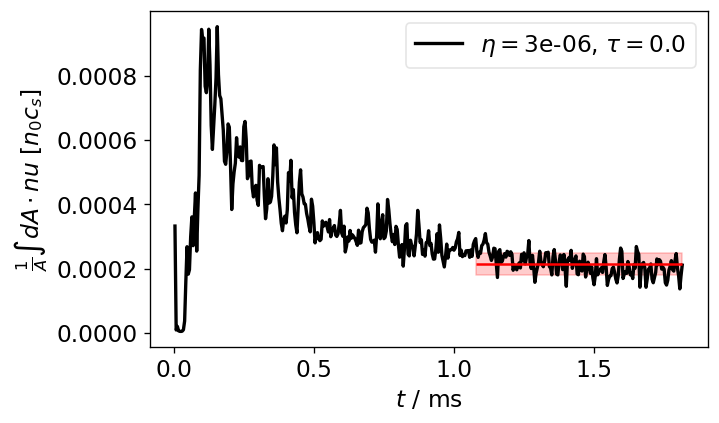

Average flux is 3.84e-04 pm 1.01e-04
Total average energy loss rate is 1890.3
Total energy gain by sources is 16237.1
Energy confinement time = 8.99e+01


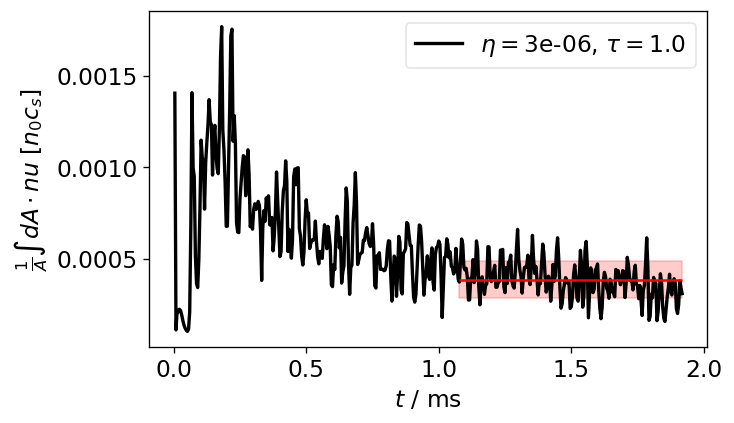

Average flux is 3.13e-04 pm 4.67e-05
Total average energy loss rate is 1538.0
Total energy gain by sources is 9473.3
Energy confinement time = 7.38e+01


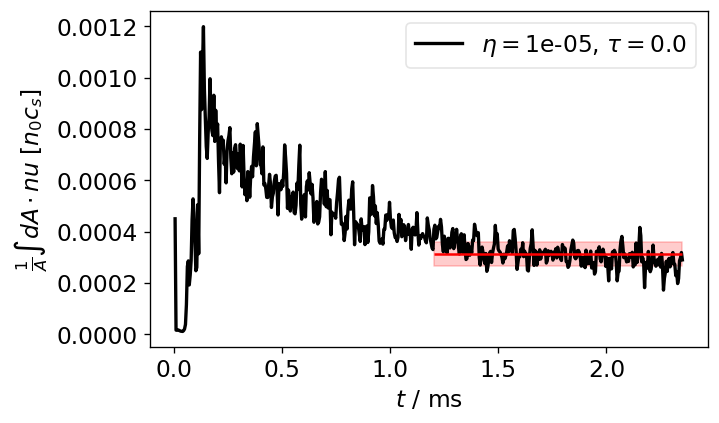

Average flux is 6.91e-04 pm 1.44e-04
Total average energy loss rate is 3398.0
Total energy gain by sources is 18885.4
Energy confinement time = 6.62e+01


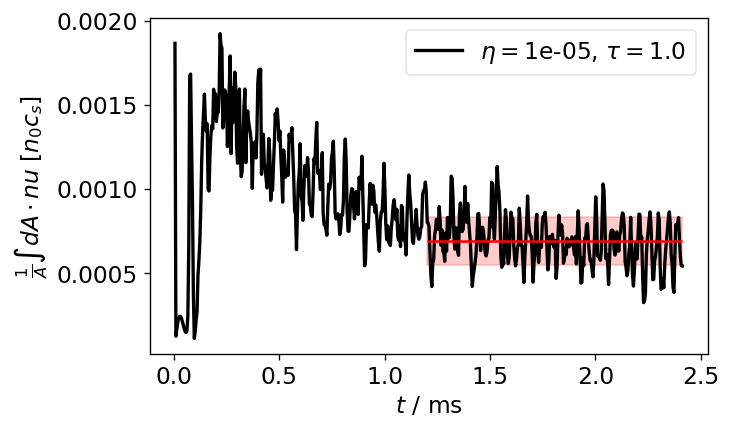

Average flux is 4.33e-04 pm 5.89e-05
Total average energy loss rate is 2129.9
Total energy gain by sources is 13698.1
Energy confinement time = 7.19e+01


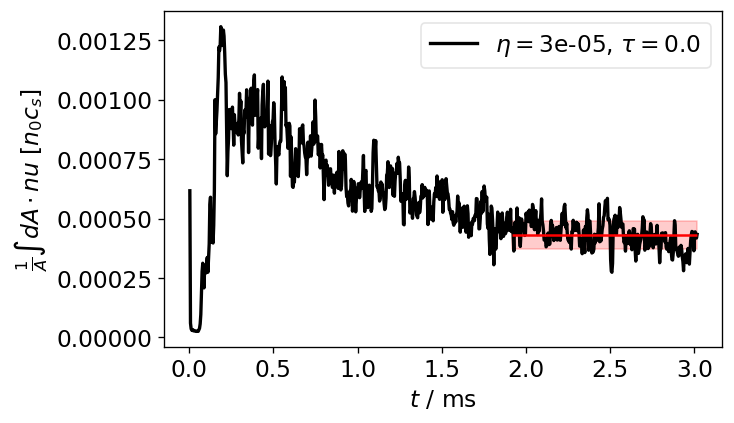

Average flux is 1.07e-03 pm 1.53e-04
Total average energy loss rate is 5254.8
Total energy gain by sources is 27153.9
Energy confinement time = 5.63e+01


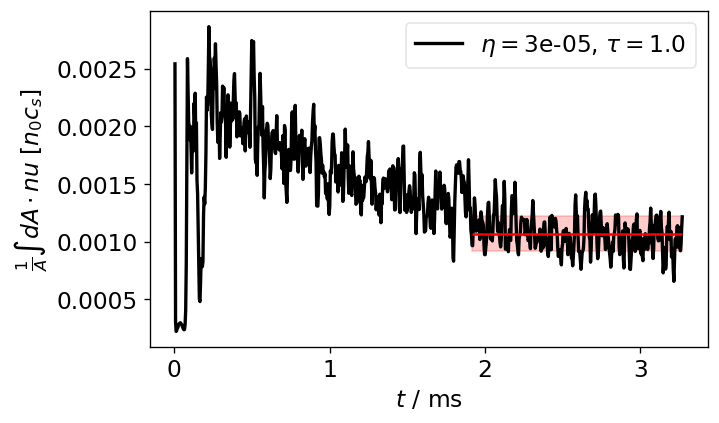

Average flux is 1.04e-03 pm 1.11e-04
Total average energy loss rate is 5108.9
Total energy gain by sources is 27629.8
Energy confinement time = 4.40e+01


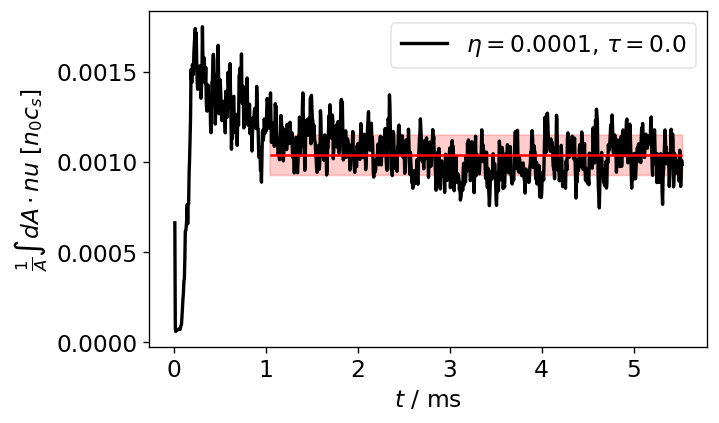

Average flux is 3.31e-03 pm 4.03e-04
Total average energy loss rate is 16277.8
Total energy gain by sources is 53547.0
Energy confinement time = 2.46e+01


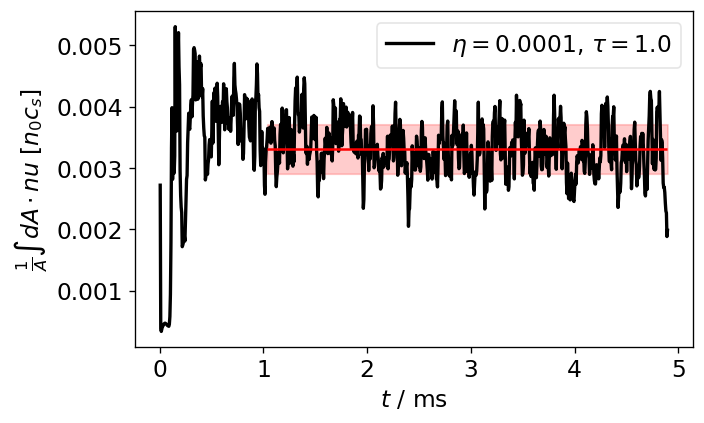

Average flux is 3.36e-03 pm 2.87e-04
Total average energy loss rate is 16517.1
Total energy gain by sources is 54135.7
Energy confinement time = 1.77e+01


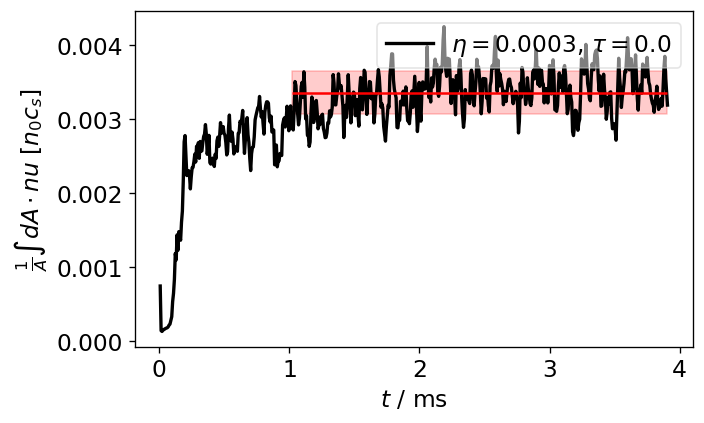

Average flux is 1.00e-02 pm 1.17e-03
Total average energy loss rate is 49403.8
Total energy gain by sources is 103869.1
Energy confinement time = 1.02e+01


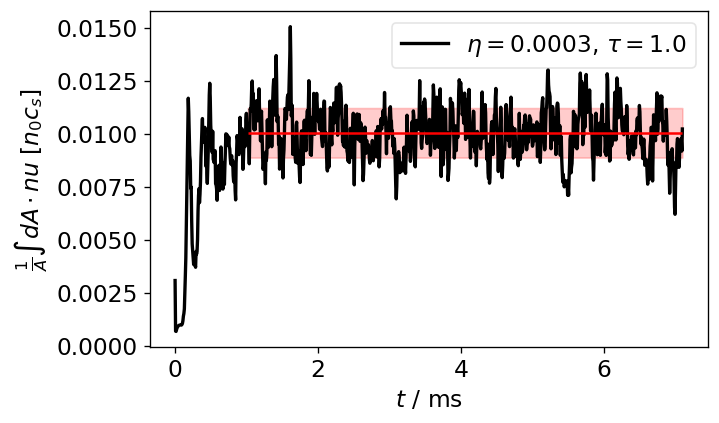

In [112]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    
    da = pp['file']
 
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)

    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]

#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['ue2_ifs_lcfs'][:])
    mass+=np.asarray(da['nelnne_ifs_lcfs'][:])
    mass+=np.asarray(da['nilnni_ifs_lcfs'][:])
    mass+=np.asarray(da['neue2_ifs_lcfs'][:])
    mass+=np.asarray(da['niui2_ifs_lcfs'][:])
    mass+=np.asarray(da['aperp2_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    jvne = da.variables['jvee_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jvei_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jveea_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jveia_tt_ifs_lcfs'][:]/deltat
    average_mass = np.mean(mass[min_idx:])
    sigma_mass = mass[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    #### Fill in parameters list #####
    pp['physical']['average_energy_flux_lcfs'] = average_jvne
    pp['physical']['average_energy_ifs'] = average_mass
    pp['physical']['sigma_energy_flux_lcfs'] = sigma_jvne
    pp['physical']['sigma_energy_ifs'] = sigma_mass
    ###################################
    source =da.variables['see_tt_ifs_lcfs'][:]/deltat
    source+=da.variables['sei_tt_ifs_lcfs'][:]/deltat
    average_source = source[min_idx:].mean()
    area = pp['area'][pp['lcfs']]
    print( f"Average flux is { average_jvne/area:1.2e} pm {sigma_jvne/area:1.2e}")
    print( f"Total average energy loss rate is {average_jvne:6.1f}")
    print( f"Total energy gain by sources is {average_source:6.1f}" )
    print( f"Energy confinement time = {average_mass/average_jvne*timescale:1.2e}")
    tau = mass/jvne

    plt.plot(time[1:]*timescale,jvne[1:]/area, color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}')
    plt.hlines(average_jvne/area, time[min_idx]*timescale, time[-1]*timescale, color='r')
    plt.fill_between( time[min_idx:]*timescale, (average_jvne-sigma_jvne)/area, 
                      (average_jvne+sigma_jvne)/area, color='red', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ /\ $ms")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    if pp['physical']['tau'] == 1 and pp['physical']['resistivity'] == 1e-4:
        plt.savefig( 'energy-flux.png',bbox_inches='tight')
    plt.show(   )


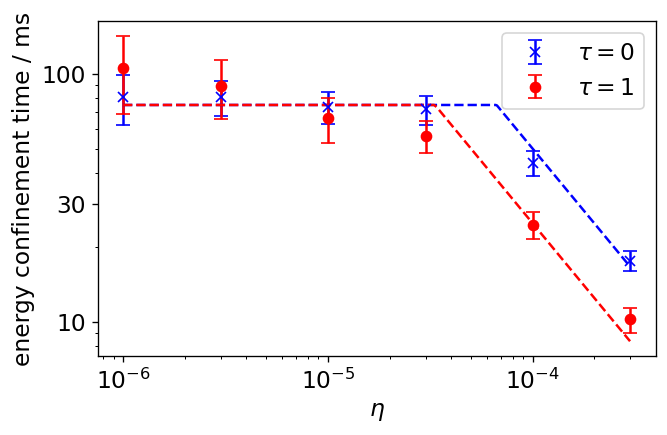

In [113]:
resistivities = {0: [], 1: []}
confinement_times = {0: [], 1: []}
confinement_errs = {0: [], 1: []}

for pp in content:
    phys= pp['physical']
    resistivities[phys['tau']].append(phys['resistivity'])
    timescale = fp.omega_0_inv(**phys)*1e3 # ms
#     timescale = 1./545.# in cs/R_0
    confinement_times[phys['tau']].append(
        phys['average_energy_ifs']/phys['average_energy_flux_lcfs']*timescale)
 
    confinement_errs[phys['tau']].append(
        np.sqrt((phys['sigma_energy_ifs']/phys['average_energy_flux_lcfs'])**2 + 
                (phys['average_energy_ifs']/phys['average_energy_flux_lcfs']**2*phys['sigma_energy_flux_lcfs'])**2)*
                timescale)
models = {0: [], 1: []}
lin_res = np.arange( 1e-6, 3e-4, 1e-6)
for res in lin_res:
    if res > 2*3.3e-5: 
        models[0].append(
            2*2.5e-7*(1e-4*res)**(-1)
        )
    else:
        models[0].append(75)
    if res > 3.3e-5: 
        models[1].append(
            2.5e-7*(1e-4*res)**(-1)
        )
    else:
        models[1].append(75)

##########################
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
# Plot error bar 
# label axes
ax.errorbar( resistivities[0], confinement_times[0],
             yerr=confinement_errs[0], marker='x', ls='',label=r'$\tau=0$',
            color = 'b',capsize=4)
ax.errorbar( resistivities[1], confinement_times[1],
             yerr=confinement_errs[1], marker='o', ls='',label=r'$\tau=1$',
            color = 'r',capsize=4)
ax.plot( lin_res, models[0], ls='--', color = 'b')
ax.plot( lin_res, models[1], ls='--', color = 'r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\eta$')
ax.set_ylabel('energy confinement time / ms')
# Rewrite the y labels
ax.yaxis.set_major_formatter(tck.StrMethodFormatter('{x:.0f}'))
# ax.yaxis.set_minor_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.set_yticks( [10,30,100])

plt.legend()
plt.savefig('energy_confinement_time.png',bbox_inches='tight')
plt.show()

Let's be careful with too general conclusions about the two regimes. The equations are fairly basic with isothermal assumption. There could still be hidden systematic numerical issues (e.g. turbulence in low resistivity does not reach core region?)

Resistivity = 1e-06, $\tau=$0.0
Average diff =  156.8094008081343


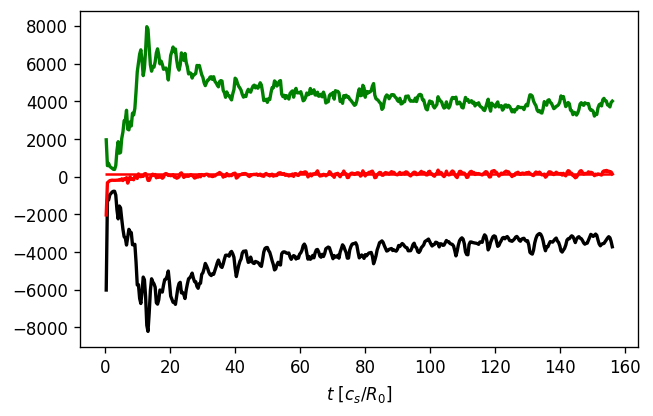

Resistivity = 1e-06, $\tau=$1.0
Average diff =  56.77640146739592


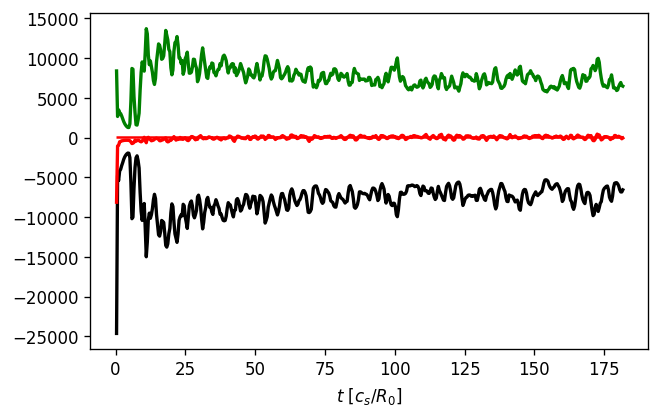

Resistivity = 3e-06, $\tau=$0.0
Average diff =  130.0226390362251


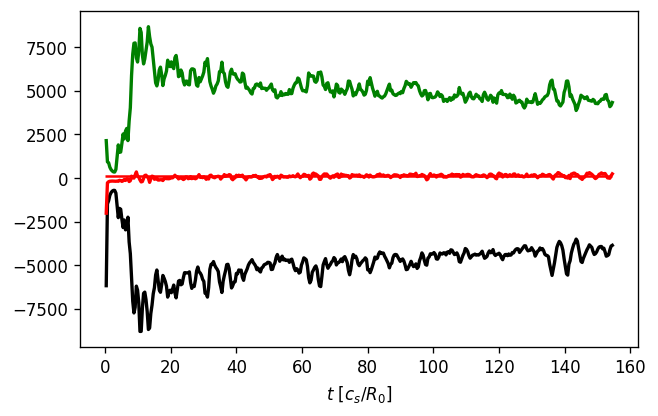

Resistivity = 3e-06, $\tau=$1.0
Average diff =  38.04283840108084


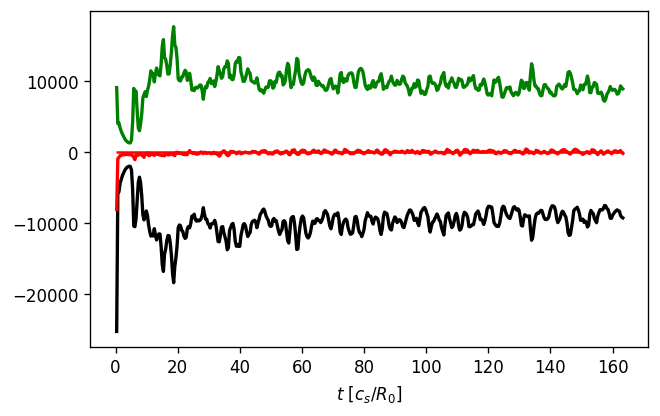

Resistivity = 1e-05, $\tau=$0.0
Average diff =  76.1213546718272


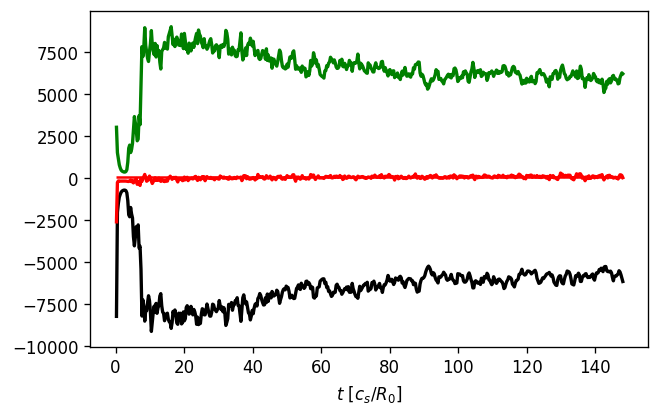

Resistivity = 1e-05, $\tau=$1.0
Average diff =  -42.51910610353536


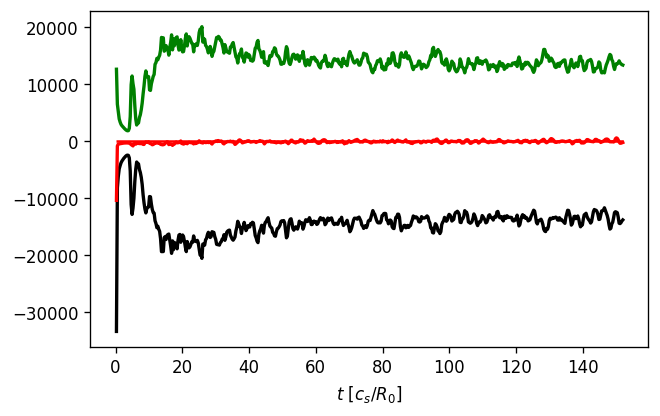

Resistivity = 3e-05, $\tau=$0.0
Average diff =  -29.50727601191097


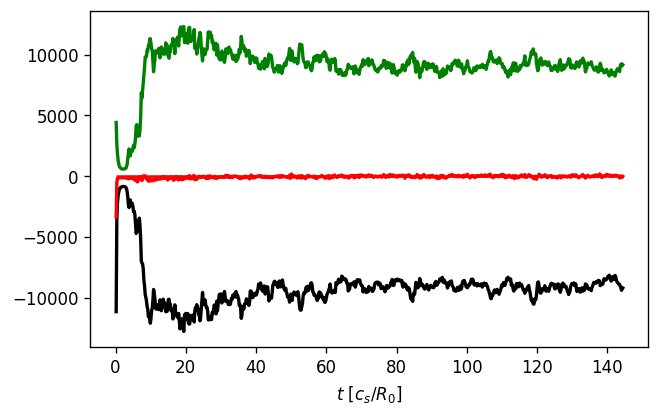

Resistivity = 3e-05, $\tau=$1.0
Average diff =  -141.74341673627626


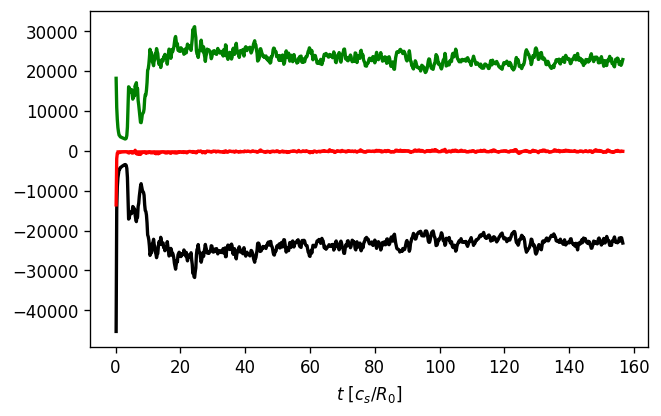

Resistivity = 0.0001, $\tau=$0.0
Average diff =  -190.97488170366685


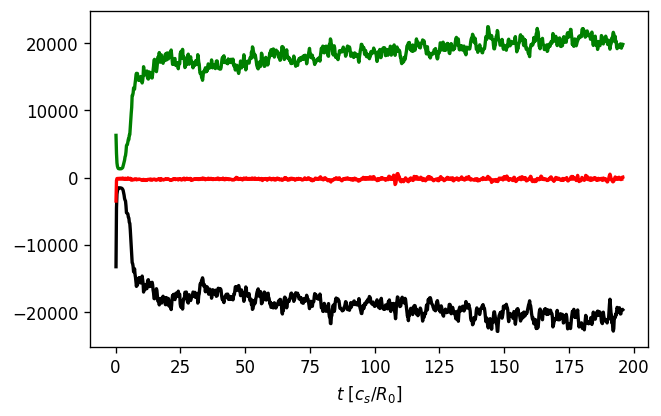

Resistivity = 0.0001, $\tau=$1.0
Average diff =  -683.4263609727822


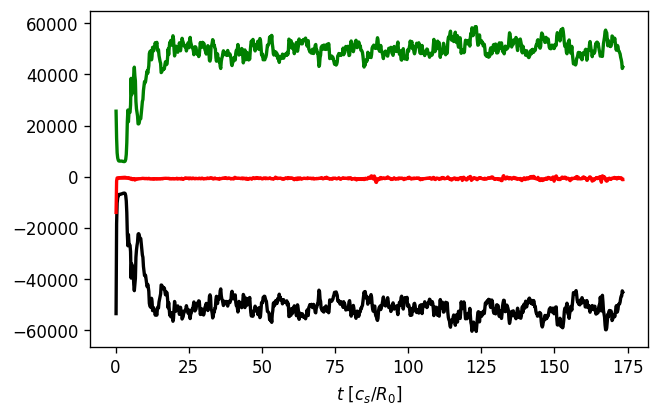

Resistivity = 0.0003, $\tau=$0.0
Average diff =  -494.8413256935717


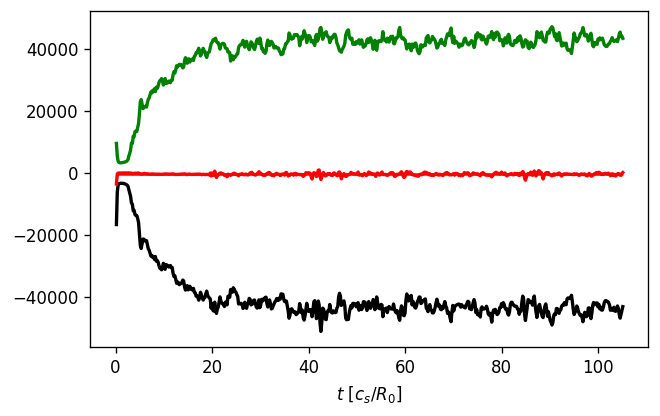

Resistivity = 0.0003, $\tau=$1.0
Average diff =  -1249.668907849915


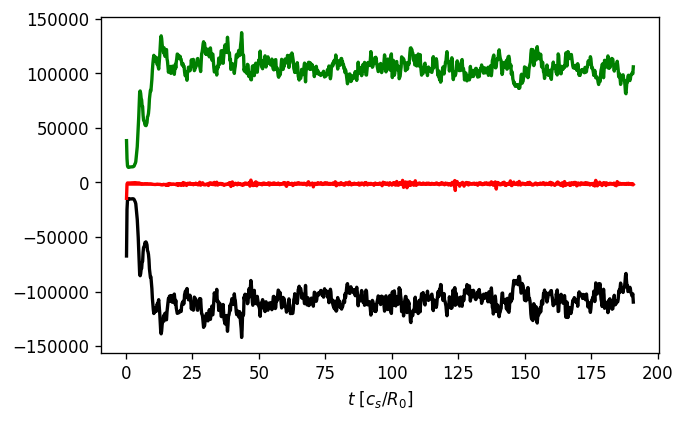

In [94]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')

    da = pp['file']
    time = np.asarray(da['time'][:])
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)

#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    mass =np.asarray(da['ue2_ifs_lcfs'][:])
    mass+=np.asarray(da['nelnne_ifs_lcfs'][:])
    mass+=np.asarray(da['nilnni_ifs_lcfs'][:])
    mass+=np.asarray(da['neue2_ifs_lcfs'][:])
    mass+=np.asarray(da['niui2_ifs_lcfs'][:])
    mass+=np.asarray(da['aperp2_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)

    deltamass = np.diff(masstt,axis=0)/deltat
    source =np.asarray(da.variables['see_tt_ifs_lcfs'][:])/deltat
    source+=np.asarray(da.variables['sei_tt_ifs_lcfs'][:])/deltat
    deltamass-=source
    jvne = np.asarray(da.variables['jvee_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(da.variables['jvei_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(da.variables['jveea_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(da.variables['jveia_tt_ifs_lcfs'][:])/deltat

    diff_perp = np.asarray(da.variables["leeperp_tt_ifs_lcfs"][:])/deltat
    diff_para = np.asarray(da.variables["leeparallel_tt_ifs_lcfs"][:])/deltat
    diff_perp+= np.asarray(da.variables["leiperp_tt_ifs_lcfs"][:])/deltat
    diff_para+= np.asarray(da.variables["leiparallel_tt_ifs_lcfs"][:])/deltat
    resistive = np.asarray(da.variables['resistivity_tt_ifs_lcfs'][:])/deltat
    rhs = jvne-diff_perp-diff_para-resistive
    diff = (deltamass + rhs)/2

    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,deltamass[1:], color='k', marker='',
              ls='-', lw=2,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=2,markeredgecolor='g', markersize=8, label="rhs")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=2,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[-1]*timescale, color='r')
#     plt.plot(time[min_idx:]*timescale,divjvnepar[min_idx:], color='g', marker='',
#              ls='--', lw = 2, label="parallel")

    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

### Average FSA Mass conservation 

Resistivity = 0.0001
Average diff =  -1.2129830947451975e-06
Average std  =  1.4463373562993187e-05
Resistivity = 3e-05
Average diff =  -2.0451504394536148e-06
Average std  =  1.8563047743271235e-05
Resistivity = 3e-06
Average diff =  -1.0937601976569085e-06
Average std  =  1.3155219840355359e-05
Resistivity = 1e-05
Average diff =  -1.0077055171892544e-06
Average std  =  1.5600864337756163e-05
Resistivity = 0.0003
Average diff =  2.4158945147765626e-06
Average std  =  2.0044670041149595e-05
Resistivity = 1e-06
Average diff =  7.581830159731254e-07
Average std  =  1.2351615511078421e-05


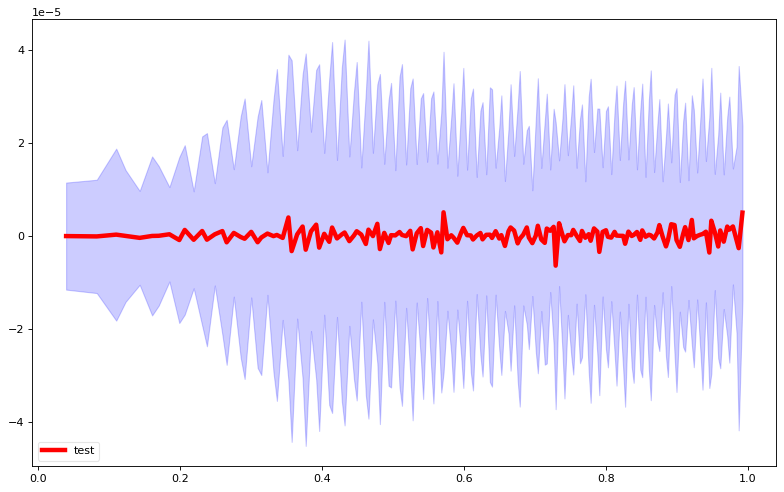

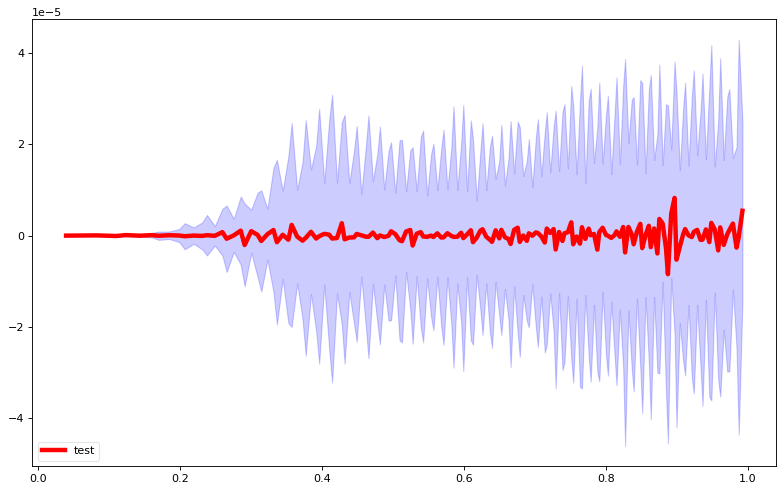

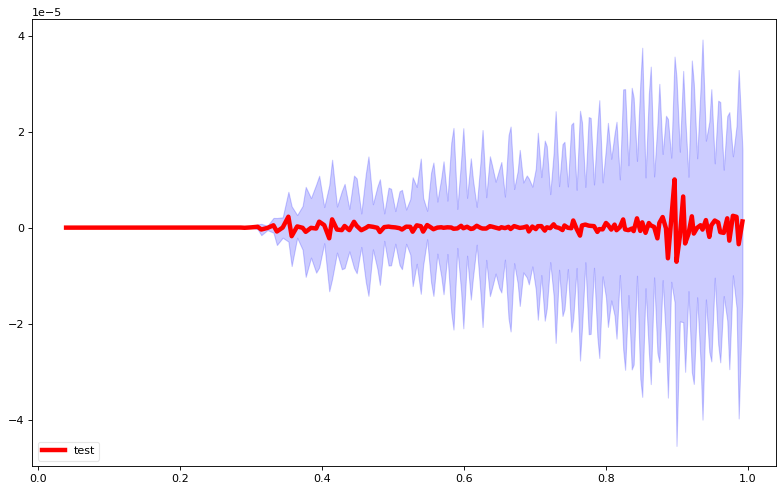

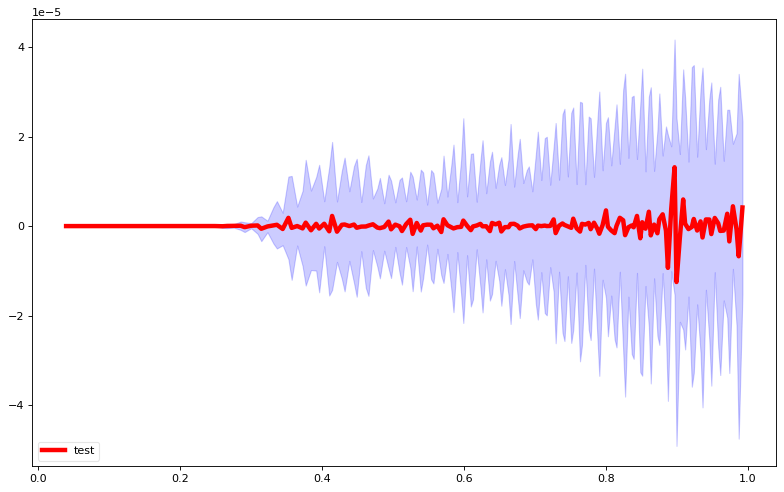

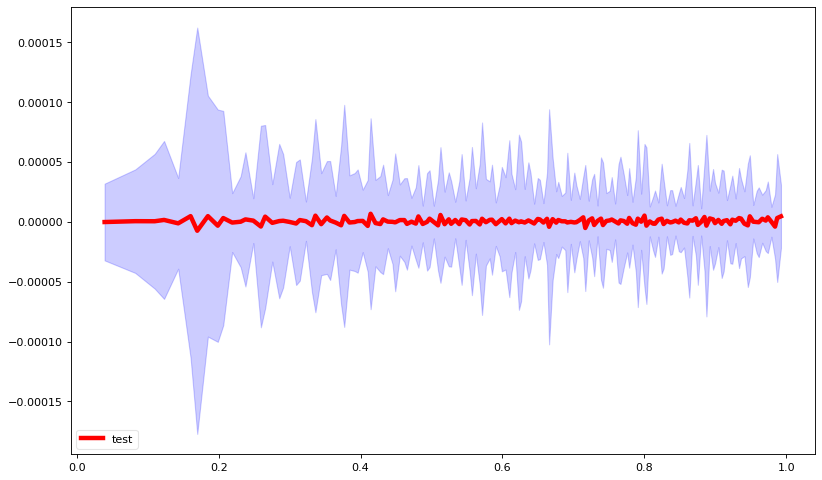

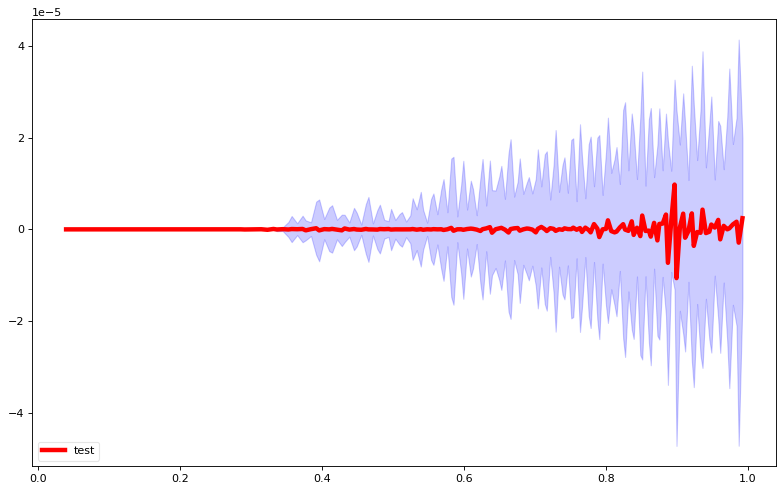

In [42]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']

    mass =np.asarray(da.variables['electrons_fsa'][:,:])
    time = np.asarray(da.variables['time'][:])
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(da.variables['sne_tt_fsa'][:,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(da.variables['jvneC_tt_ifs'][:,:])/deltat[:,None]
    jvneE=np.asarray(da.variables['jvneE_tt_ifs'][:,:])/deltat[:,None]
    jvneA=np.asarray(da.variables['jvneA_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(da.variables["lneperp_tt_fsa"][:,:])/deltat[:,None]
    diff_parallel = np.asarray(da.variables["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne-diff_perp-diff_parallel
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])

    plt.plot( pp['rho_t'][0:167], average_diff[0:167], ls = '-', color='r', lw = 2, label = 'test')
    plt.fill_between( pp['rho_t'][0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='b', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()

### Local Mass conservation on LCFS

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  -0.0006610757866361277
Average std  =  0.007882538591831295
Invert for given numerical parameters
Resistivity = 3e-05
Average diff =  -0.0011146069895022212
Average std  =  0.010116861020082822
Invert for given numerical parameters
Resistivity = 3e-06
Average diff =  -0.0005960993077230167
Average std  =  0.007169594812993675
Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  -0.0005491995068681432
Average std  =  0.00850247106407711
Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  0.0009894748941788457
Average std  =  0.007345113437856183
Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  0.00041320974370535424
Average std  =  0.0067316304535377375


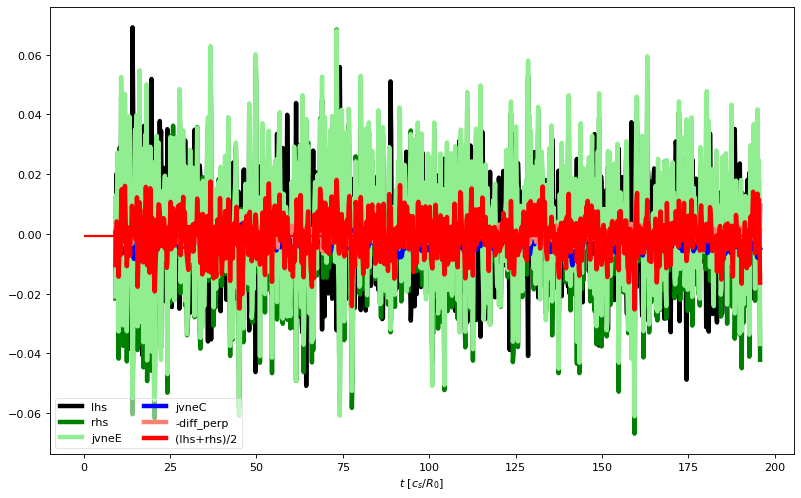

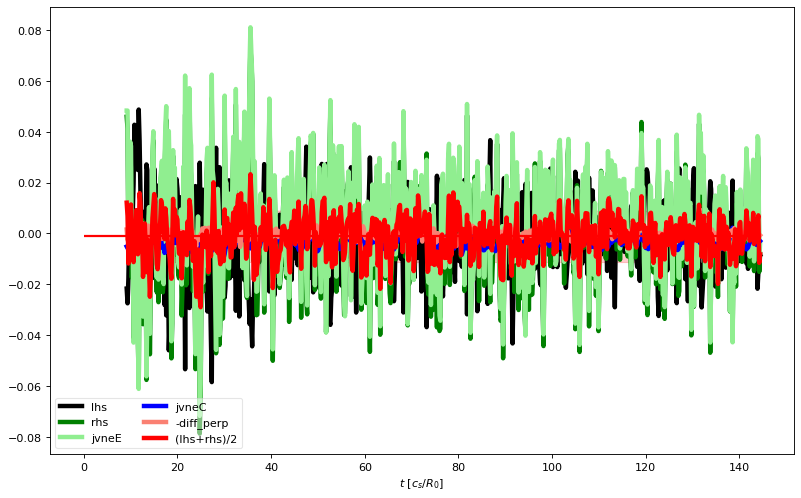

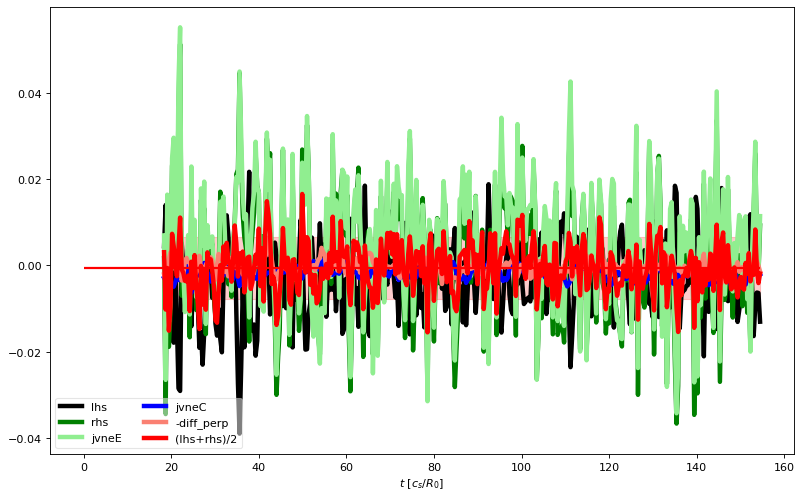

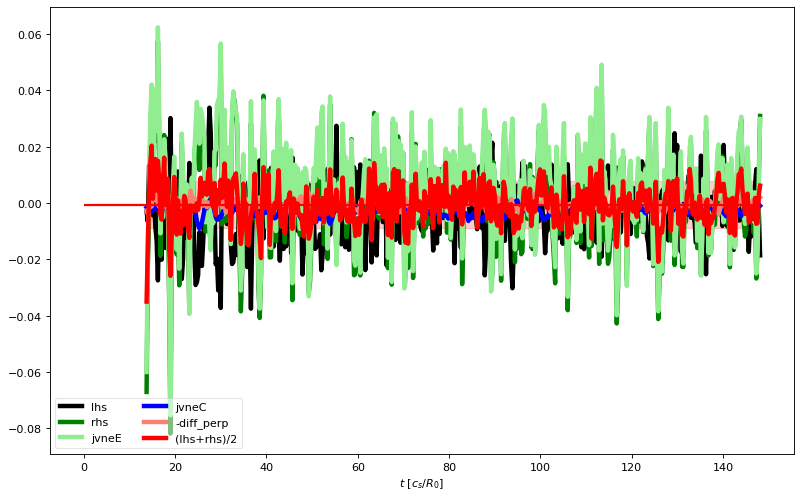

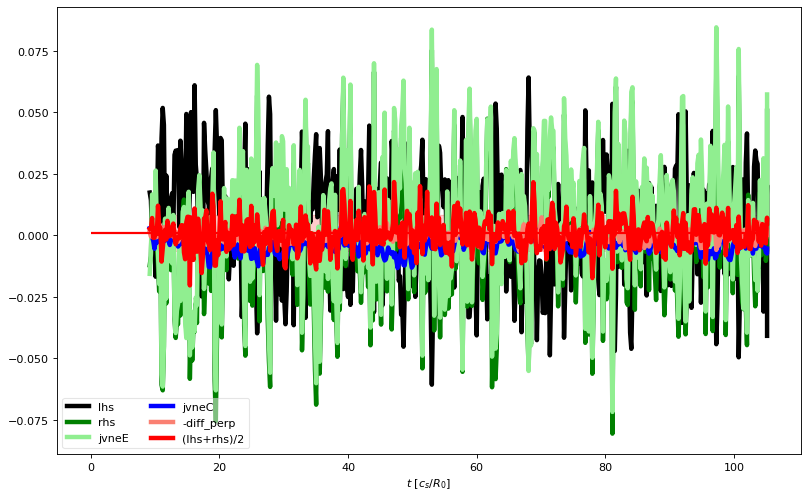

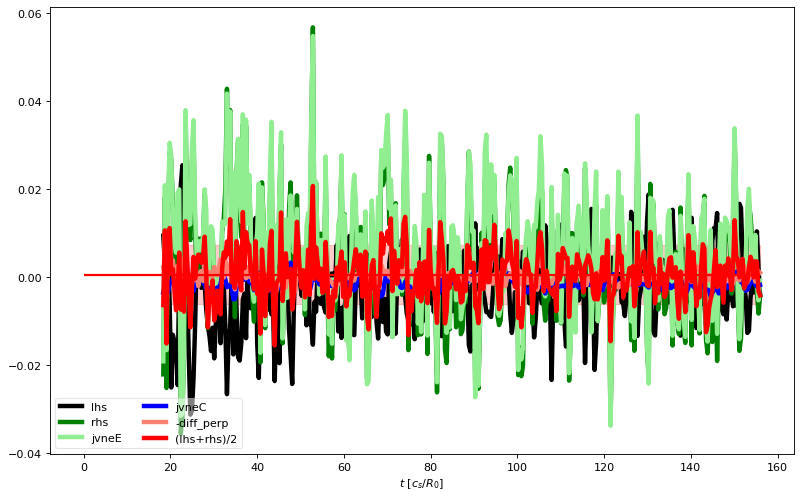

In [43]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']

    mass =np.asarray(da.variables['electrons_fsa'][:,:])

#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    time = np.asarray(da.variables['time'][:])*timescale
    timett = np.append(2*time[-1] -time[-2], time ) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(da.variables['sne_tt_fsa'][:,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(da.variables['jvneC_tt_ifs'][:,:])/deltat[:,None]
    jvneE=np.asarray(da.variables['jvneE_tt_ifs'][:,:])/deltat[:,None]
    jvneA=np.asarray(da.variables['jvneA_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(da.variables["lneperp_tt_fsa"][:,:])/deltat[:,None]
    diff_parallel = np.asarray(da.variables["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne-diff_perp-diff_parallel
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    min_idx = 50
    plt.plot(time[min_idx:],deltamass[min_idx:,idx], color='k', marker='',
              ls='-',lw=2, label="lhs")
    plt.plot(time[min_idx:],rhs[min_idx:,idx], color='g',
              ls='-', lw = 2,  label="rhs")
    plt.plot(time[min_idx:],jvneE[min_idx:,idx], color='lightgreen',
              ls='-', lw = 2, label="jvneE")
    plt.plot(time[min_idx:],jvneC[min_idx:,idx], color='blue',
              ls='-', lw = 2, label="jvneC")
    plt.plot(time[min_idx:],-diff_perp[min_idx:,idx], color='salmon',
              ls='-', lw = 2,  label="-diff_perp")
    plt.plot(time[min_idx:],diff[min_idx:,idx], color='r',
              ls='-', lw = 2,  label="(lhs+rhs)/2")
    plt.hlines(average_diff[idx], time[0], time[-1], color='r', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    plt.xlabel(r"$t\ [c_s/R_0]$")

### Density profile

Invert for given numerical parameters
Resistivity = 0.0001
Dataset length  1068
Average region  36.69724770642202 195.7798165137615
Invert for given numerical parameters
Resistivity = 3e-05
Dataset length  788
Average region  91.74311926605505 144.40366972477065
Invert for given numerical parameters
Resistivity = 3e-06
Dataset length  422
Average region  91.74311926605505 154.4954128440367
Invert for given numerical parameters
Resistivity = 1e-05
Dataset length  539
Average region  75.68807339449542 148.07339449541286
Invert for given numerical parameters
Resistivity = 0.0003
Dataset length  575
Average region  27.522935779816514 105.14436992288653
Invert for given numerical parameters
Resistivity = 1e-06
Dataset length  426
Average region  91.74311926605505 155.9633027522936


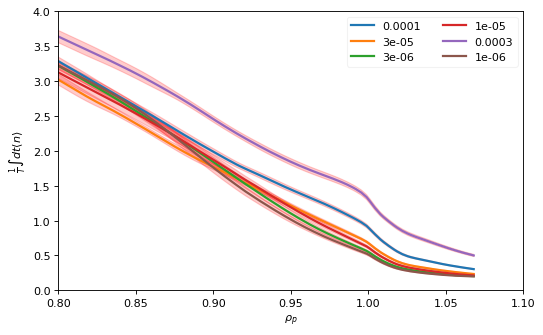

In [44]:

fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')
for pp in content :
    da = pp['file']

    time = np.asarray(da.variables['time'][:])
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    density =da.variables['electrons_fsa'][:]
    source = da.variables['sne_tt_fsa'][:]

#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Dataset length ", len(time))
    print( "Average region ", time[min_idx]*timescale, time[-1]*timescale)
    avg_density=density[min_idx:-1].mean(axis=0)
    std_density=density[min_idx:-1].std(axis=0)
    avg_source = source.mean(axis=0)
    plt.plot( pp['rho_p'], avg_density, ls='-', lw=2, label=f'{pp["physical"]["resistivity"]}')
    # plt.plot( pp['rho_t'], density[-1,:],color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( pp['rho_t'], avg_source*1000,color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( pp['rho_t'],   -psi_p*3+1, ls='--', color = 'k')
#     plt.plot( pp['rho_p'],   -psi_p/2+1, ls='--', color = 'k')
    plt.fill_between( pp['rho_p'], (avg_density-std_density), 
                      (avg_density+std_density), color='red', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.25)
    da.close()
ax.axvspan(0, 0.4, alpha=0.25, color='red')

plt.xlabel(r"$\rho_p$")
# plt.xlabel(r"$\sqrt{\psi_p/\psi_{O}}$")

plt.ylabel(r"$\frac{1}{T}\int dt \langle n\rangle$")
plt.xlim(0.8,1.1)
plt.ylim(0,4)
plt.show(  )

### Vorticity accuracy on LCFS

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 0.0001
Average diff =  2.466283967634978e-07
Average std  =  1.0396396555812737e-06


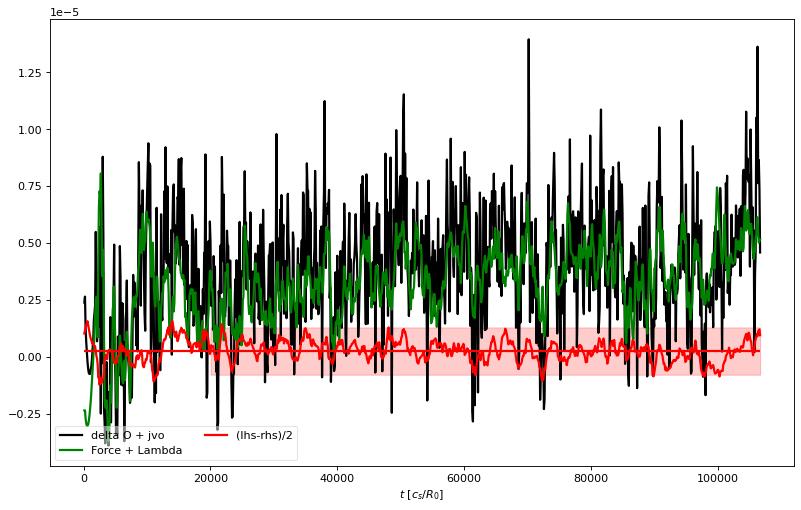

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 3e-05
Average diff =  -1.9851020263740847e-08
Average std  =  9.627977303930211e-07


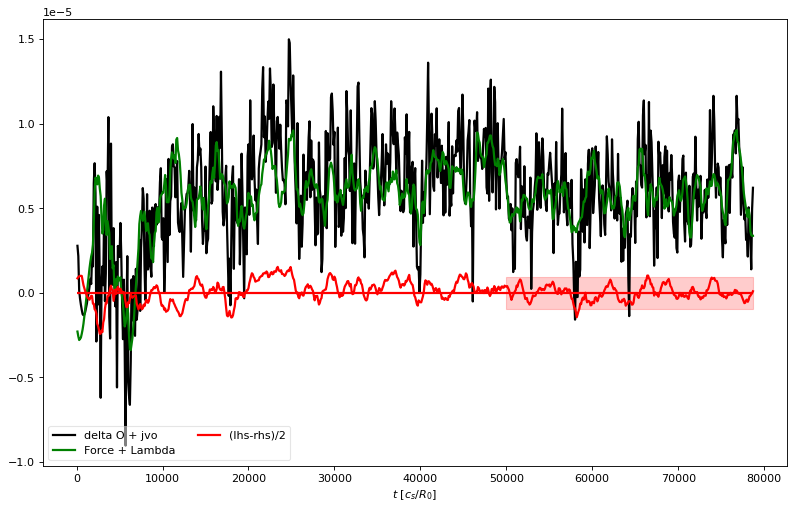

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 3e-06
Average diff =  -4.230502166908733e-07
Average std  =  7.603247152391759e-07


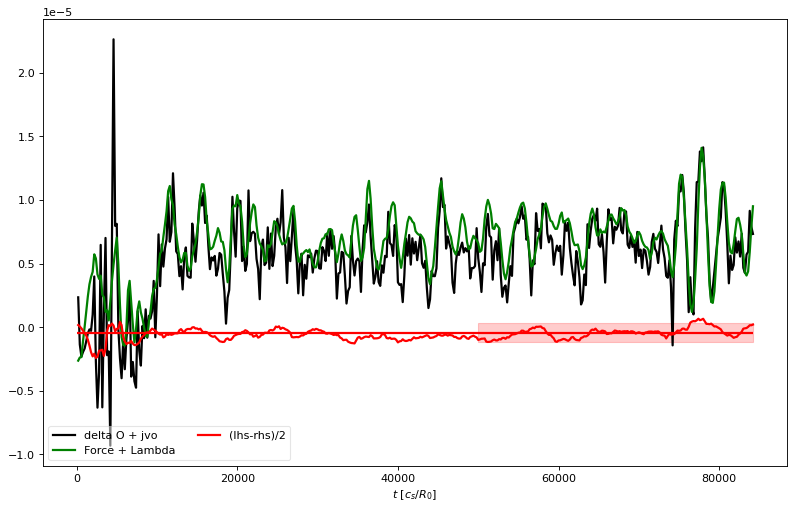

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 1e-05
Average diff =  -2.896524907923258e-07
Average std  =  7.865039130722585e-07


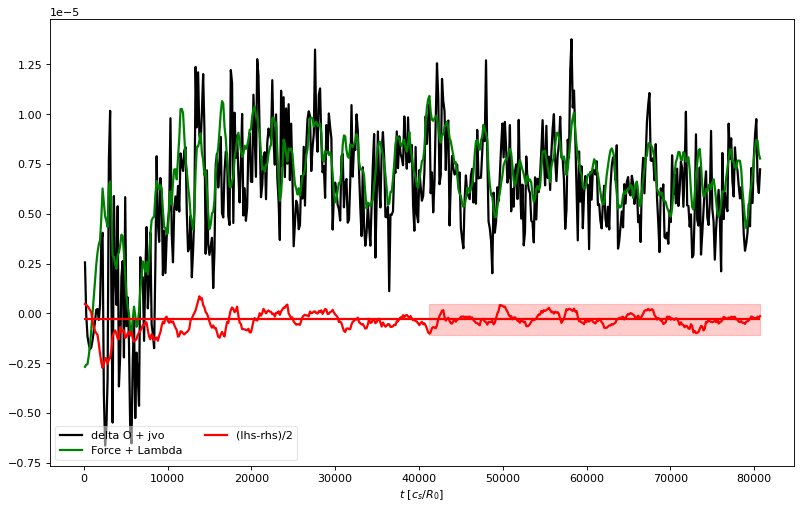

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 0.0003
Average diff =  8.506725848168261e-07
Average std  =  8.543249351476292e-07


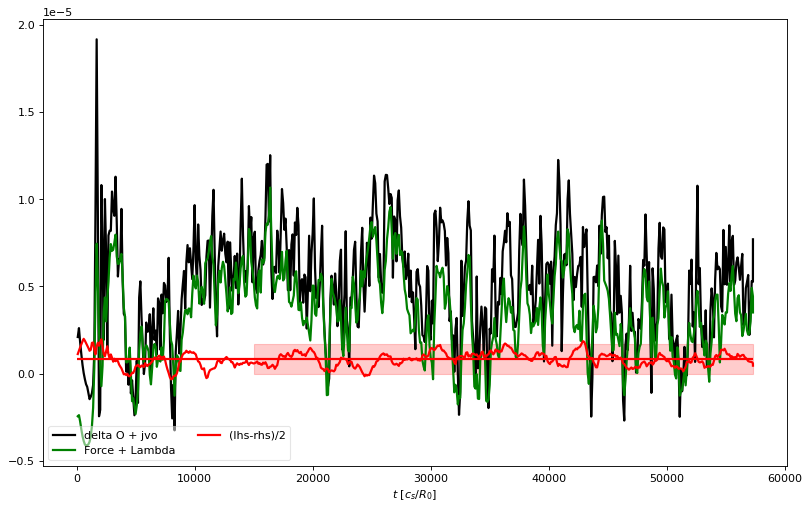

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 1e-06
Average diff =  -6.086569119721767e-07
Average std  =  5.891185386358538e-07


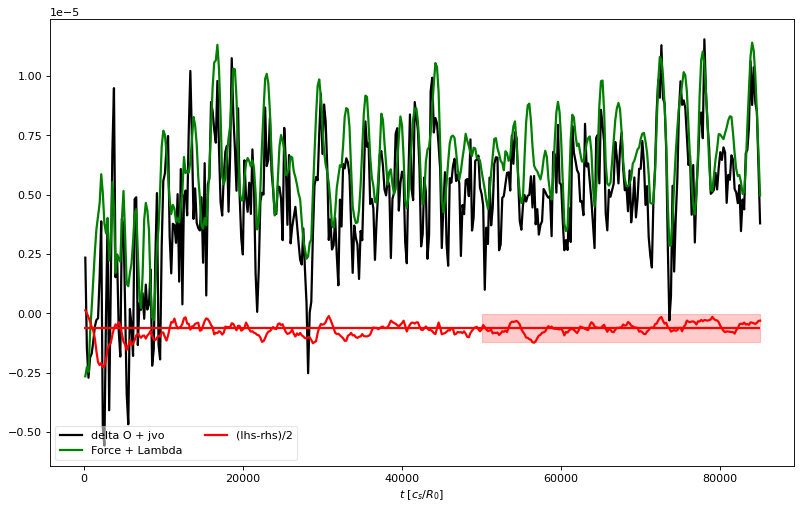

In [71]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']

    time = np.asarray(da['time'][:])
    timett = np.append(2*time[-1] -time[-2], time ) # extrapolate
    deltat = np.diff(timett)

    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0   
#     vorticity = da['vorticity_fsa'][:,:]
#     el = da['electrons_ifs'][:,:]
#     ions = da['ions_ifs'][:,:]
#     dvdpsip=da['dvdpsi'][:]
#     vorticity = (el-ions)/dvdpsip
    vorticity =np.asarray(da['oexbe_fsa'][:,:])
    # vorticity+=da['odiae_fsa'][:,:]
    # vorticity/=da['electrons_fsa'][:,:]
    tttvorticity=np.append(np.zeros((1,len(pp['rho_t']))),vorticity, axis=0)
    deltavorticity = np.diff(tttvorticity,axis=0)/deltat[:,None]
    jvoE= np.asarray(da['jvoexbe_tt_ifs'][:,:])/deltat[:,None]
    jvoD= np.asarray(da['jvoexbeUD_tt_ifs'][:,:])/deltat[:,None]
    # jvoD= da.variables['jvodiaeUE_tt_ifs'][:,:]/deltat[:,None]
    maxwell= np.asarray(da['jvoapar_tt_ifs'][:,:])/deltat[:,None]
    jvoA= np.asarray(da['jvoexbApar_tt_ifs'][:,:])/deltat[:,None]
    # jvoA= da['jvodiaApar_tt_ifs'][filter,:]/deltat[:,None]
    jvo = jvoE + jvoD + maxwell + jvoA
    force = -np.asarray(da["socurve_tt_fsa"][:,:])/deltat[:,None]
    force -= np.asarray(da["socurvi_tt_fsa"][:,:])/deltat[:,None]
    force -= np.asarray(da["socurvkappae_tt_fsa"][:,:])/deltat[:,None]
    force -= np.asarray(da["socurvkappai_tt_fsa"][:,:])/deltat[:,None]
    # force2 = -da["curvne_tt_ifs"][:,:]/deltat[:,None]/dvdpsi[:]
    # source = da["sosne_tt_fsa"][:,:]/deltat[:,None]
    # source+= da["sospi_tt_fsa"][:,:]/deltat[:,None]
    lamb = np.asarray(da["loexbe_tt_fsa"][:,:])/deltat[:,None]
    #lamb = da['lneperp_tt_ifs'][:,:]/deltat[:,None]

    #lamb = lamb/dvdpsip[None,:]
    lhs = deltavorticity + jvo
    rhs = -force+lamb#-source
    # diff = +deltavorticity + rhs
    diff = (lhs-rhs)/2
    # delayed_diff = (deltavorticity[0:-1,:]+rhs[1:,:])/2
    average_diff = np.mean( diff[min_idx:], axis=0)
    average_std = np.std( diff[min_idx:], axis=0)
    # rhs = rhs - 2*average_diff[None, :]
    # diff = ( deltavorticity + rhs)/2

    idx= pp['lcfs']
    print( "Index 167 vs lcfs", pp['lcfs'])
    print( idx, ' vs ' pp['rho_t'][idx])
    
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    plt.plot(time[1:],lhs[1:,idx], color='k', marker='',
              ls='-',lw=2,markeredgecolor='k', markersize=8, label="delta O + jvo")
    plt.plot(time[1:],rhs[1:,idx], color='g', marker='',
              ls='-', lw = 2, markeredgecolor='k', markersize=8, label="Force + Lambda")
    plt.plot(time[1:],np.convolve(diff[1:,idx],np.ones(10)/10, mode='same'), color='r', marker='',
              ls='-', lw = 2, markeredgecolor='k', markersize=8, label="(lhs-rhs)/2")
#     plt.plot(time[1:],jvoE[1:,idx], color='salmon', marker='',
#               ls='--', lw = 2, markeredgecolor='k', markersize=8, label="jvoE")
# #     plt.plot(time[1:],jvoD[1:,idx], color='lightblue', marker='',
# #               ls='-', lw = 2, markeredgecolor='k', markersize=8, label="jvoD")
# #     plt.plot(time[min_idx:],-source[min_idx:,idx], color='crimson', marker='',
# #               ls='-', lw = 2, markeredgecolor='k', markersize=8, label="-source")
#     plt.plot(time[1:],force[1:,idx], color='y', marker='',
#               ls='--', lw = 2, markeredgecolor='k', markersize=8, label="force")
# #     plt.plot(time[1:],jvoA[1:,idx], color='orange', marker='',
# #               ls='-', lw = 2, markeredgecolor='k', markersize=8, label="jvoA")
#     plt.plot(time[1:],maxwell[1:,idx], color='c', marker='',
#               ls='--', lw = 2, markeredgecolor='k', markersize=8, label="Maxwell")
#     plt.plot(time[1:],-lamb[1:,idx], color='lightyellow', marker='',
#               ls='--', lw = 2, markeredgecolor='k', markersize=8, label="-lambda")
    plt.hlines(average_diff[idx], time[0], time[-1], color='r', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    # print(time[-1])
    # idx = np.where( time[np.where( time < 9356)]>9354)
    # print( idx[0][0] )
    # plt.plot( pp['rho_t'], force[ idx[0][0],: ], color='y', label = "force")
    # plt.plot( pp['rho_t'], jvo[ idx[0][0],: ], color='r', label = "jvo")
    # plt.plot( pp['rho_t'], deltavorticity[ idx[0][0],: ], color='g', label = "dO")
    
    
    # plt.plot( pp['rho_t'], average_diff, ls = '-', color=v[0], lw = 2, label = v[1])
    # plt.fill_between( pp['rho_t'][0:167], average_diff[0:167]-average_std[0:167], 
    #                   average_diff[0:167]+average_std[0:167], color=v[0], alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    # plt.xlabel(r"$\pp['rho_t']$")
    # plt.xlim(0,6)
    # plt.ylabel(r"$\int dV \Omega_E$")
    #plt.xlim(6360,6400)
    # plt.xlim(0,1.0)
    # plt.ylim(-2e-2,2e-2)

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.show(   )

## Ion toroidal momentum plot

Invert for given numerical parameters


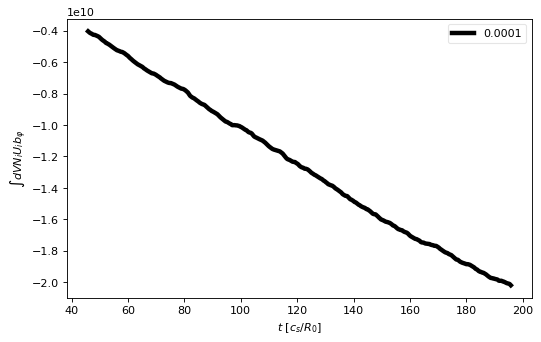

Invert for given numerical parameters


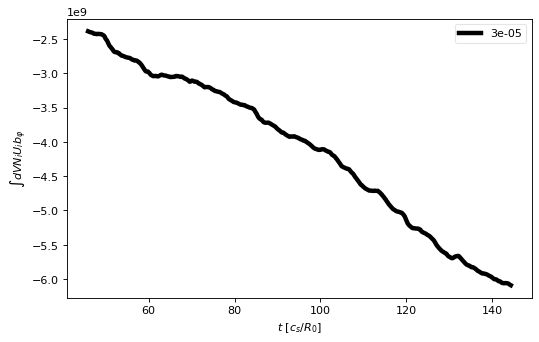

Invert for given numerical parameters


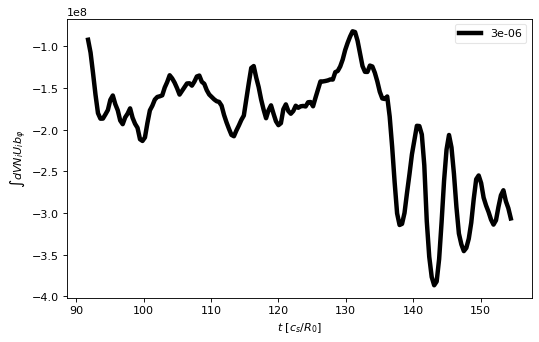

Invert for given numerical parameters


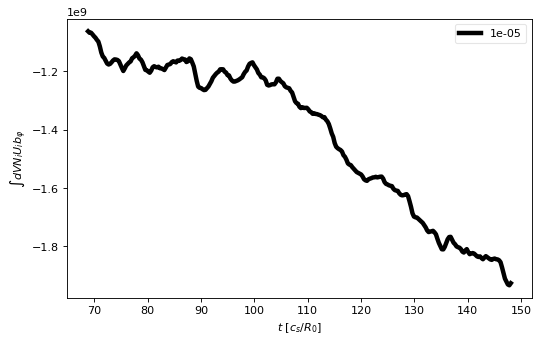

Invert for given numerical parameters


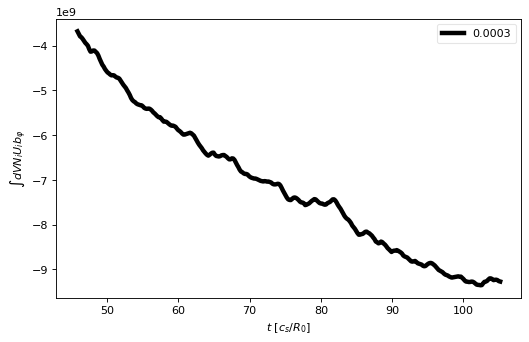

Invert for given numerical parameters


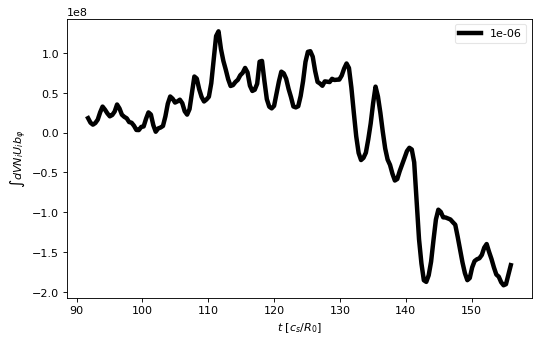

In [73]:
for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = da.variables['time'][:]*timescale
    
    niuibphi = da.variables['niuibphi_ifs_lcfs'][:]
    oexb = da.variables['oexbi_ifs_lcfs'][:]

    plt.plot(time[min_idx:],niuibphi[min_idx:], color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=f'{pp["physical"]["resistivity"]}')
#     plt.plot(time[min_idx:],oexb[min_idx:], color='g', 
#          marker='',ls='-', lw=2,markeredgecolor='k', markersize=8
#          )
#     plt.plot(time[min_idx:],niuibphi[min_idx:]-oexb[min_idx:], color='r', 
#          marker='',ls='-', lw=2,markeredgecolor='r', markersize=8
#          )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\int dV  N_iU_ib_\varphi$")

    plt.show(   )

### Ion toroidal momentum accuracy

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  -294982.93579150527


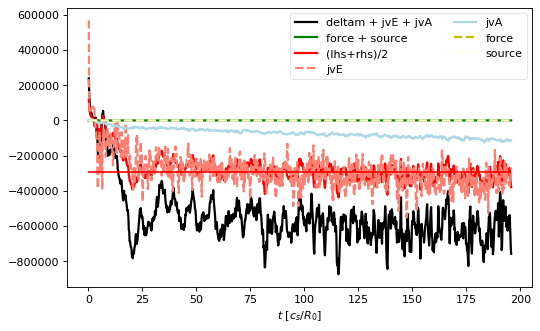

Invert for given numerical parameters
Resistivity = 3e-05
Average diff =  -185939.40253672903


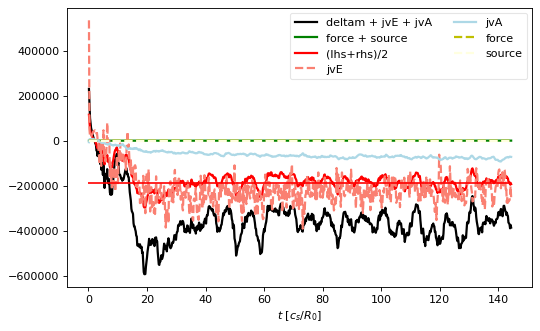

Invert for given numerical parameters
Resistivity = 3e-06
Average diff =  -129070.39504918017


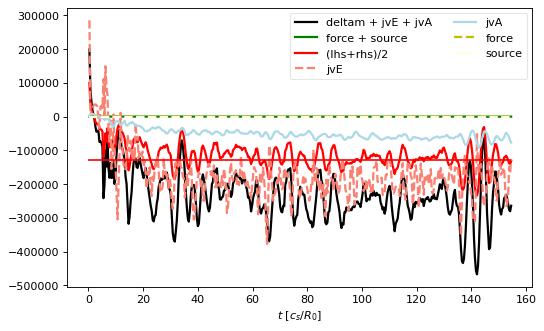

Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  -148307.79649932412


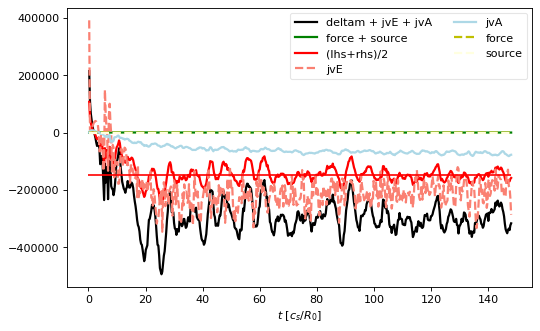

Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  -354079.8881887614


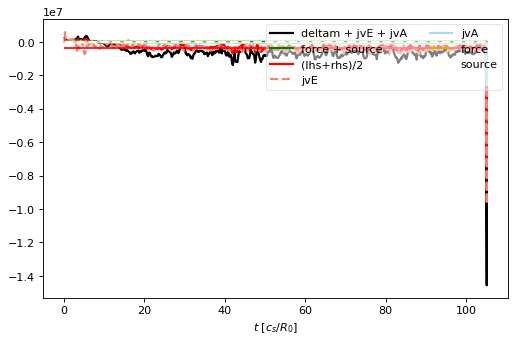

Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  -113664.97842648251


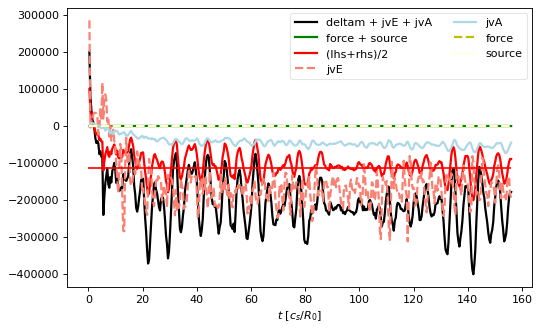

In [77]:
for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
    
#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = da.variables['time'][:]
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    
    
    mass =np.asarray(da.variables['niuibphi_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltam = np.diff(masstt,axis=0)/deltat

    source = np.asarray(da.variables['sparsnibphi_tt_ifs_lcfs'][:])/deltat
    
    jvneE = np.asarray(da['jvparbphiexbi_tt_ifs_lcfs'][:])/deltat
    jvneA = np.asarray(da['jvparbphiApar_tt_ifs_lcfs'][:])/deltat
    
    force = -np.asarray(da.variables["socurve_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(da.variables["socurvi_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(da.variables["socurvkappae_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(da.variables["socurvkappai_tt_ifs_lcfs"][:])/deltat
    lhs = deltam + jvneE + jvneA
    rhs = -force + source
    diff = (lhs - rhs)/2
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,lhs[1:], color='k', marker='',
              ls='-', lw=2,markeredgecolor='k', markersize=8, label="deltam + jvE + jvA")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=2,markeredgecolor='g', markersize=8, label="force + source")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=2,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.plot(time[1:]*timescale,jvneE[1:], color='salmon', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="jvE")
    plt.plot(time[1:]*timescale,jvneA[1:], color='lightblue', marker='',
              ls='-', lw = 2, markeredgecolor='k', markersize=8, label="jvA")
    plt.plot(time[1:]*timescale,force[1:], color='y', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="force")
    plt.plot(time[1:]*timescale,source[1:], color='lightyellow', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="source")
    plt.hlines(average_diff, time[0]*timescale, time[-1]*timescale, color='r')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

## Ion parallel momentum

Invert for given numerical parameters
Resistivity = 0.0001
timescale = 0.001834862385321101
Average diff =  -160.8261195553935


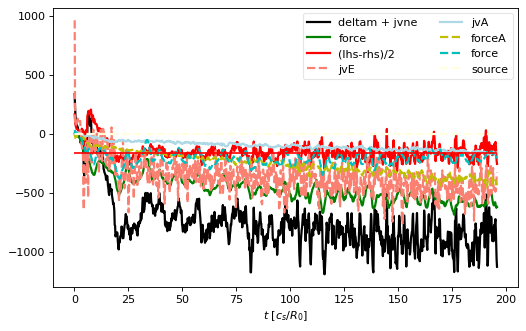

Invert for given numerical parameters
Resistivity = 3e-05
timescale = 0.001834862385321101
Average diff =  -67.37092641408046


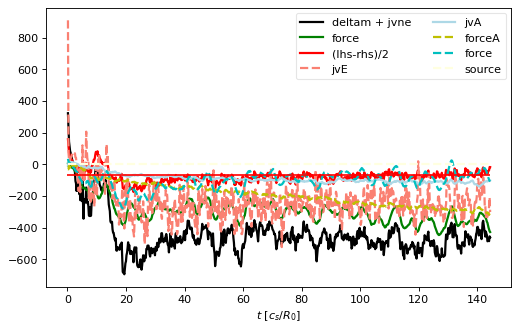

Invert for given numerical parameters
Resistivity = 3e-06
timescale = 0.001834862385321101
Average diff =  -55.1555840894456


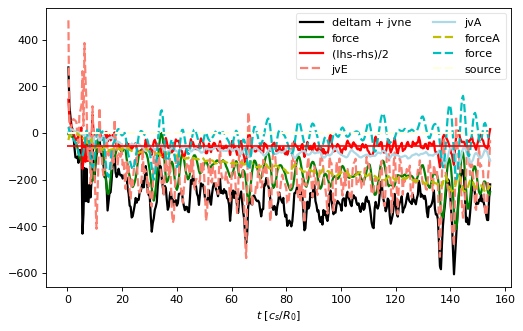

Invert for given numerical parameters
Resistivity = 1e-05
timescale = 0.001834862385321101
Average diff =  -69.11298494402736


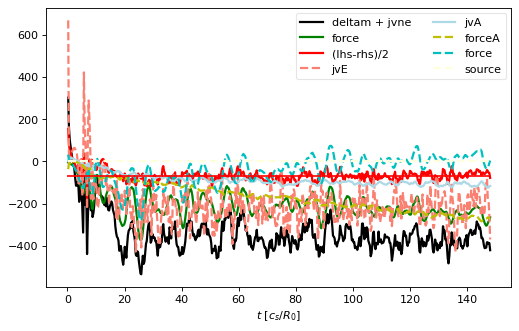

Invert for given numerical parameters
Resistivity = 0.0003
timescale = 0.001834862385321101
Average diff =  -132.51834248357048


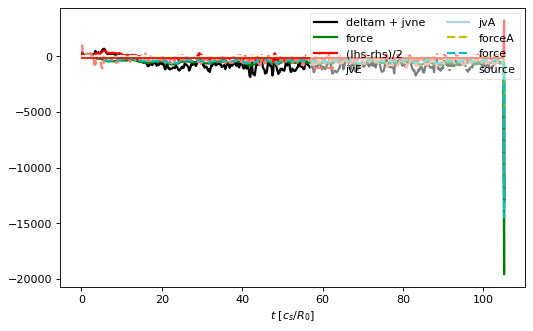

Invert for given numerical parameters
Resistivity = 1e-06
timescale = 0.001834862385321101
Average diff =  -46.07121860356081


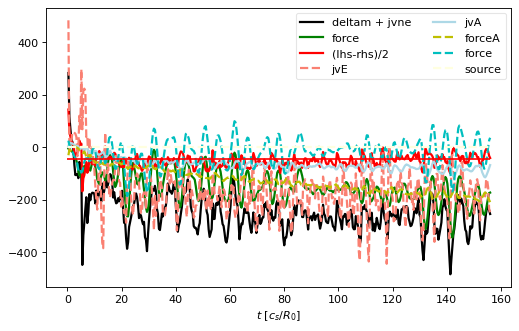

In [96]:
# content = []
# content.append( full_content[3])
for pp in content :
    da = pp['file']
    
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')

#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = da.variables['time'][:]
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    
    mass =np.asarray(da['niui_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltam = np.diff(masstt,axis=0)/deltat

    source = np.asarray(da['sparsni_tt_ifs_lcfs'][:])/deltat
    
    jvneE = np.asarray(da['jvparexbi_tt_ifs_lcfs'][:])/deltat
    jvneA = np.asarray(da['jvparApar_tt_ifs_lcfs'][:])/deltat
    jvneD = np.asarray(da['jvpardiai_tt_ifs_lcfs'][:])/deltat
    jvneK = np.asarray(da['jvparkappai_tt_ifs_lcfs'][:])/deltat
#     divjpar = np.asarray(da['divjpare_tt_ifs_lcfs'][:])/deltat
#     divjpar += np.asarray(da['divjpari_tt_ifs_lcfs'][:])/deltat
    force  = np.asarray(da["sparmirrore_tt_ifs_lcfs"][:])/deltat
    force += np.asarray(da["sparmirrori_tt_ifs_lcfs"][:])/deltat
    
    forceA = ( 1. + pp["physical"]["tau"])*np.asarray(da['sparmirrorAe_tt_ifs_lcfs'][:])/deltat # !! important part !!
    lhs = deltam + jvneE + jvneA + jvneD + jvneK #+ divjpar
    rhs = force  + forceA
    diff = (lhs - rhs)/2
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print(f'timescale = {timescale}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,lhs[1:], color='k', marker='',
              ls='-', lw=2,markeredgecolor='k', markersize=8, label="deltam + jvne")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=2,markeredgecolor='g', markersize=8, label="force")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=2,markeredgecolor='r', markersize=8, label="(lhs-rhs)/2")
    plt.plot(time[1:]*timescale,jvneE[1:], color='salmon', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="jvE")
    plt.plot(time[1:]*timescale,jvneA[1:], color='lightblue', marker='',
              ls='-', lw = 2, markeredgecolor='k', markersize=8, label="jvA")
    plt.plot(time[1:]*timescale,forceA[1:], color='y', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="forceA")
    plt.plot(time[1:]*timescale,force[1:], color='c', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="force")
    plt.plot(time[1:]*timescale,source[1:], color='lightyellow', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="source")
    plt.hlines(average_diff, time[0]*timescale, time[-1]*timescale, color='r')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

## Parallel electron force balance

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  -11.396957083204947


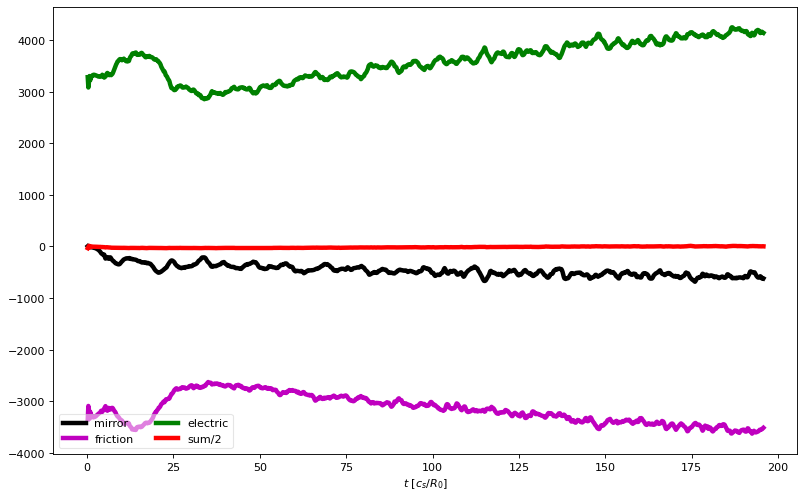

Invert for given numerical parameters
Resistivity = 3e-05
Average diff =  -59.57200107081225


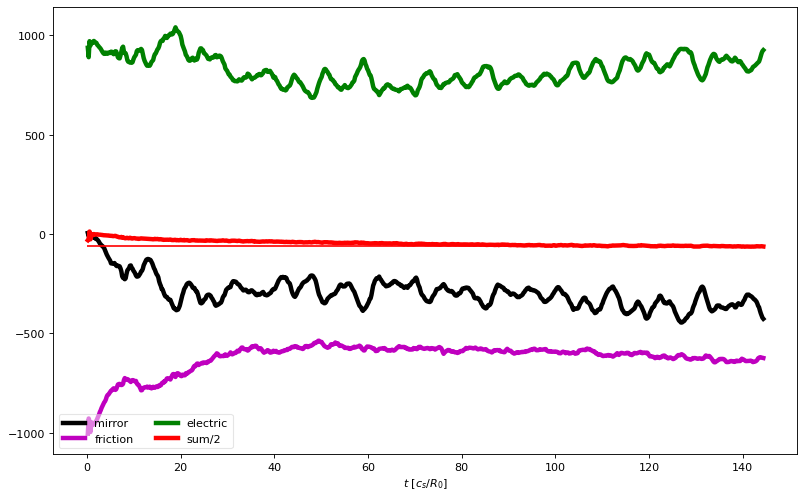

Invert for given numerical parameters
Resistivity = 3e-06
Average diff =  -71.3040361255576


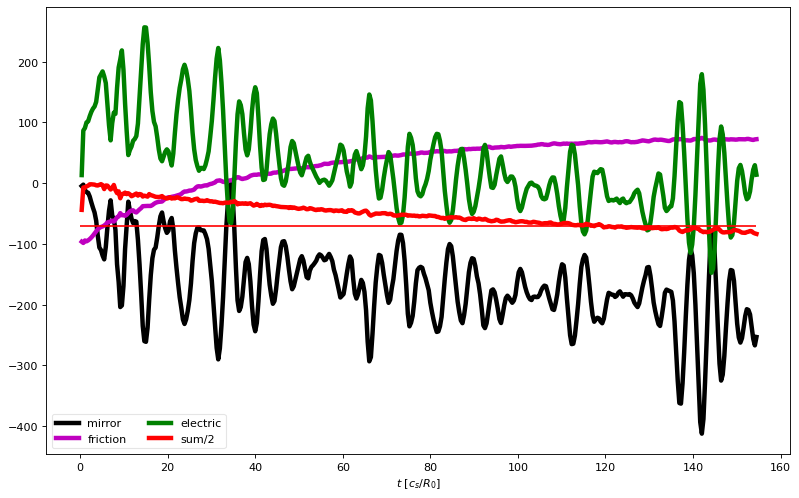

Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  -71.73504734036003


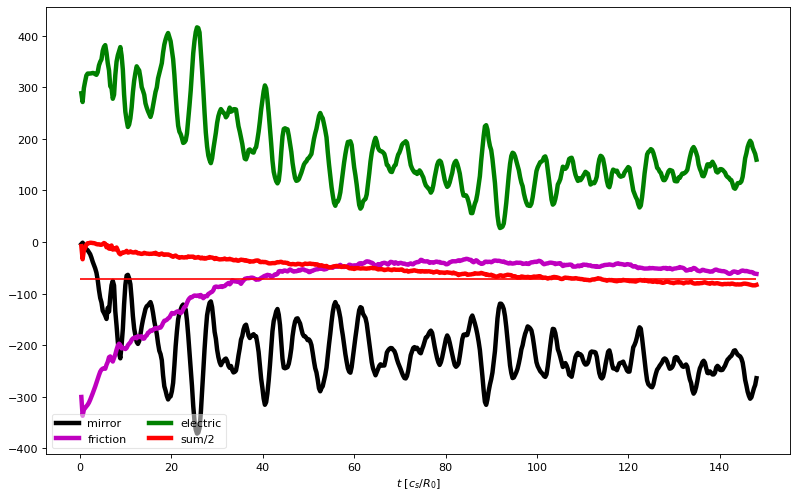

Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  13.693364996759135


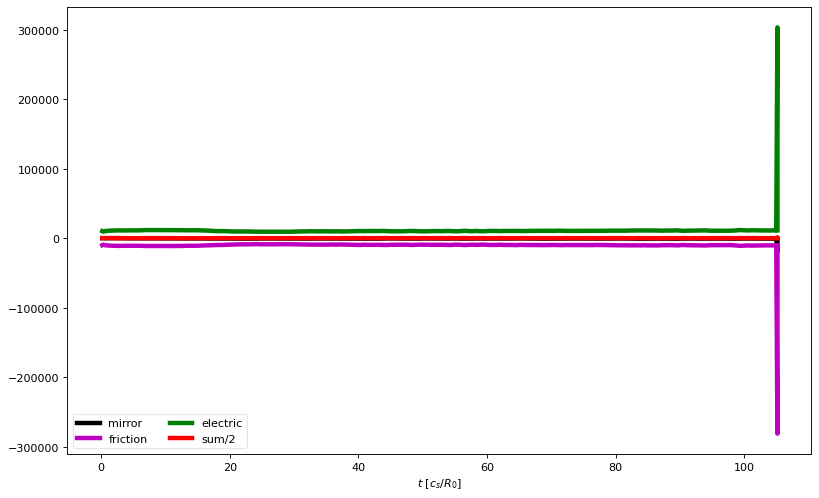

Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  -62.2878681241647


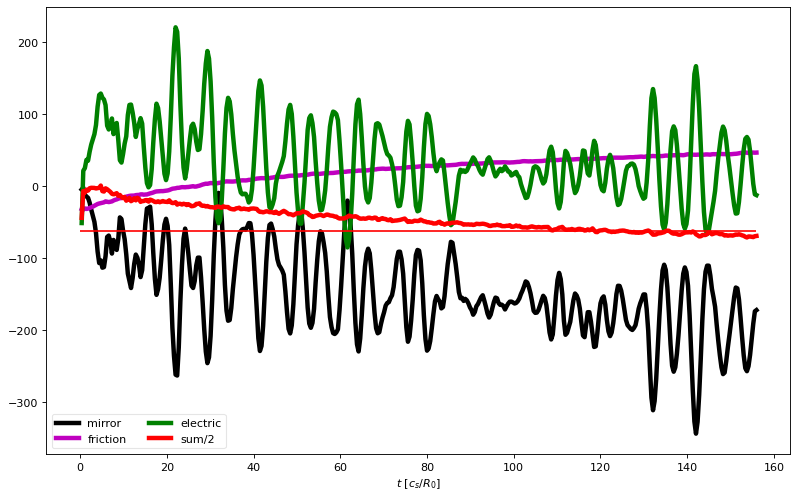

In [88]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
    
    time = np.asarray(da['time'][:])
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)

#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    mass =np.asarray(da['sparmirrore_tt_ifs_lcfs'][:])/deltat
    mass+=np.asarray(da['sparmirrorAe_tt_ifs_lcfs'][:])/deltat
    source =np.asarray(da['friction_tt_ifs_lcfs'][:])/deltat

    jvne = np.asarray(da['sparphie_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(da['sparphiAe_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(da['spardotAe_tt_ifs_lcfs'][:])/deltat
    lhs = mass + source
    rhs = jvne
    diff = (lhs + rhs)/2
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,mass[1:], color='k', marker='',
              ls='-', lw=2,markeredgecolor='k', markersize=8, label="mirror")
    plt.plot(time[1:]*timescale,source[1:], color='m', marker='',
              ls='-', lw=2,markeredgecolor='m', markersize=8, label="friction")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=2,markeredgecolor='g', markersize=8, label="electric")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=2,markeredgecolor='r', markersize=8, label="sum/2")
    plt.hlines(average_diff, time[0]*timescale, time[-1]*timescale, color='r')
#     plt.plot(time[min_idx:]*timescale,divjvnepar[min_idx:], color='g', marker='',
#              ls='--', lw = 2, label="parallel")
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )